In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import re
import pandas as pd
from scanf import scanf
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
figsize = (30, 16)
PWD = os.getcwd()

In [2]:
def read_data_loopup_table(psi_dir_list, tcenter, ignore_first=0):
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
#     ecoli_nodes_list = []
    ecoli_lateral_norm_list = []
    ecoli_idx_list = []
    norm_phi_list = []
    norm_psi_list = []
    norm_theta_list = []
    i0 = -1
    t1 = []
    for psi_dir in psi_dir_list:
        print(psi_dir)
        file_handle = os.path.basename(psi_dir)
        mat_names = natsort.natsorted(glob.glob('%s/%s_th*' % (psi_dir, file_handle)))
        for mati in mat_names[ignore_first:]:
            i0 = i0 + 1
            mat_contents = loadmat(mati)
            ecoli_U = mat_contents['ecoli_U'].flatten()
            ecoli_norm = mat_contents['ecoli_norm'].flatten()
            ecoli_center = mat_contents['ecoli_center'].flatten()
            planeShearRate = mat_contents['planeShearRate'].flatten()
            ecoli_nodes = mat_contents['ecoli_nodes']
            norm_phi = mat_contents['norm_phi'].flatten()
            norm_psi = mat_contents['norm_psi'].flatten()
            norm_theta = mat_contents['norm_theta'].flatten()
            ecoli_U_list.append(ecoli_U)
            ecoli_norm_list.append(ecoli_norm)
            ecoli_center_list.append(ecoli_center)
            ecoli_idx_list.append(i0)
            norm_phi_list.append(norm_phi)
            norm_psi_list.append(norm_psi)
            norm_theta_list.append(norm_theta)
            r0 = ecoli_nodes[-1] - ecoli_center
            n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
            t0 = r0 - n0
            ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))

    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
    ecoli_idx = np.hstack(ecoli_idx_list)
    norm_phi = np.hstack(norm_phi_list)
    norm_psi = np.hstack(norm_psi_list)
    norm_theta = np.hstack(norm_theta_list)
    norm_tpp = np.vstack((norm_theta, norm_phi, norm_psi)).T

    # calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
    n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
    ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
    # calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
    ecoli_center000 = ecoli_center + n_u000
    using_U = ecoli_U
    omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
    omega_tang = using_U[:, 3:] - omega_norm
    
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
           ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate

In [34]:
# interpolate using spline, 2d+1d
import datetime

importlib.reload(spf)
job_dir = 'ecoC01B00_T10'
print(datetime.datetime.now())

t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)
ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate \
  = read_data_loopup_table(psi_dir_list=psi_dir_list, tcenter=tcenter, ignore_first=0)
print(datetime.datetime.now())

2019-11-14 08:25:18.758144
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi0.00
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi0.42
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi0.84
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi1.26
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi1.68
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi2.09
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi2.51
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi2.93
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi3.35
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B00_T10/ecoC01B00_all_psi3.77
/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B0

In [35]:
norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_psi, 
                    'ecoli_U0': ecoli_U[:, 0], 
                    'ecoli_U1': ecoli_U[:, 1], 
                    'ecoli_U2': ecoli_U[:, 2], 
                    'ecoli_U3': ecoli_U[:, 3], 
                    'ecoli_U4': ecoli_U[:, 4], 
                    'ecoli_U5': ecoli_U[:, 5], 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])

ecoli_U0 = data.ecoli_U0.unstack()
ecoli_U1 = data.ecoli_U1.unstack()
ecoli_U2 = data.ecoli_U2.unstack()
ecoli_U3 = data.ecoli_U3.unstack()
ecoli_U4 = data.ecoli_U4.unstack()
ecoli_U5 = data.ecoli_U5.unstack()
use_theta_list = data.index.levels[0].values
use_phi_list = data.index.levels[1].values
use_psi_list = data.index.levels[2].values

# table_data = []
# intp_fun_list = []
# for tpsi in use_psi_list: # interpolate over 1d, psi
#     tintp_fun_list = []
#     table_psi_data = []
#     for t1 in data.columns.values: # interpolate fun for [ux,uy,uz,wx,wy,wz]
#         tu = data[t1].unstack()
#         tU = tu[tpsi].unstack()
#         tx = tU.columns.values
#         ty = tU.index.values
#         # interpolate over 2d
#         tfun = interpolate.RectBivariateSpline(ty, tx, tU)
#         tintp_fun_list.append(tfun)
#         table_psi_data.append((ty, tx, tU))
#     table_data.append((tpsi, table_psi_data))
#     intp_fun_list.append(tintp_fun_list)

table_data = []
for tpsi in use_psi_list: # interpolate over 1d, psi
    table_psi_data = []
    for t1 in data.columns.values: # interpolate fun for [ux,uy,uz,wx,wy,wz]
        tu = data[t1].unstack()
        if tu.isnull().values.any(): 
            print(tpsi, t1)
        tU = tu[tpsi].unstack()
        tx = tU.columns.values
        ty = tU.index.values
        table_psi_data.append((ty, tx, tU))
    table_data.append((tpsi, table_psi_data))
    
with open('%s.pickle' % job_dir, 'wb') as handle:
    pickle.dump(table_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save table_data to %s.pickle' % job_dir)

save table_data to ecoC01B00_T10.pickle


ecoC01B05_tau1c_passive


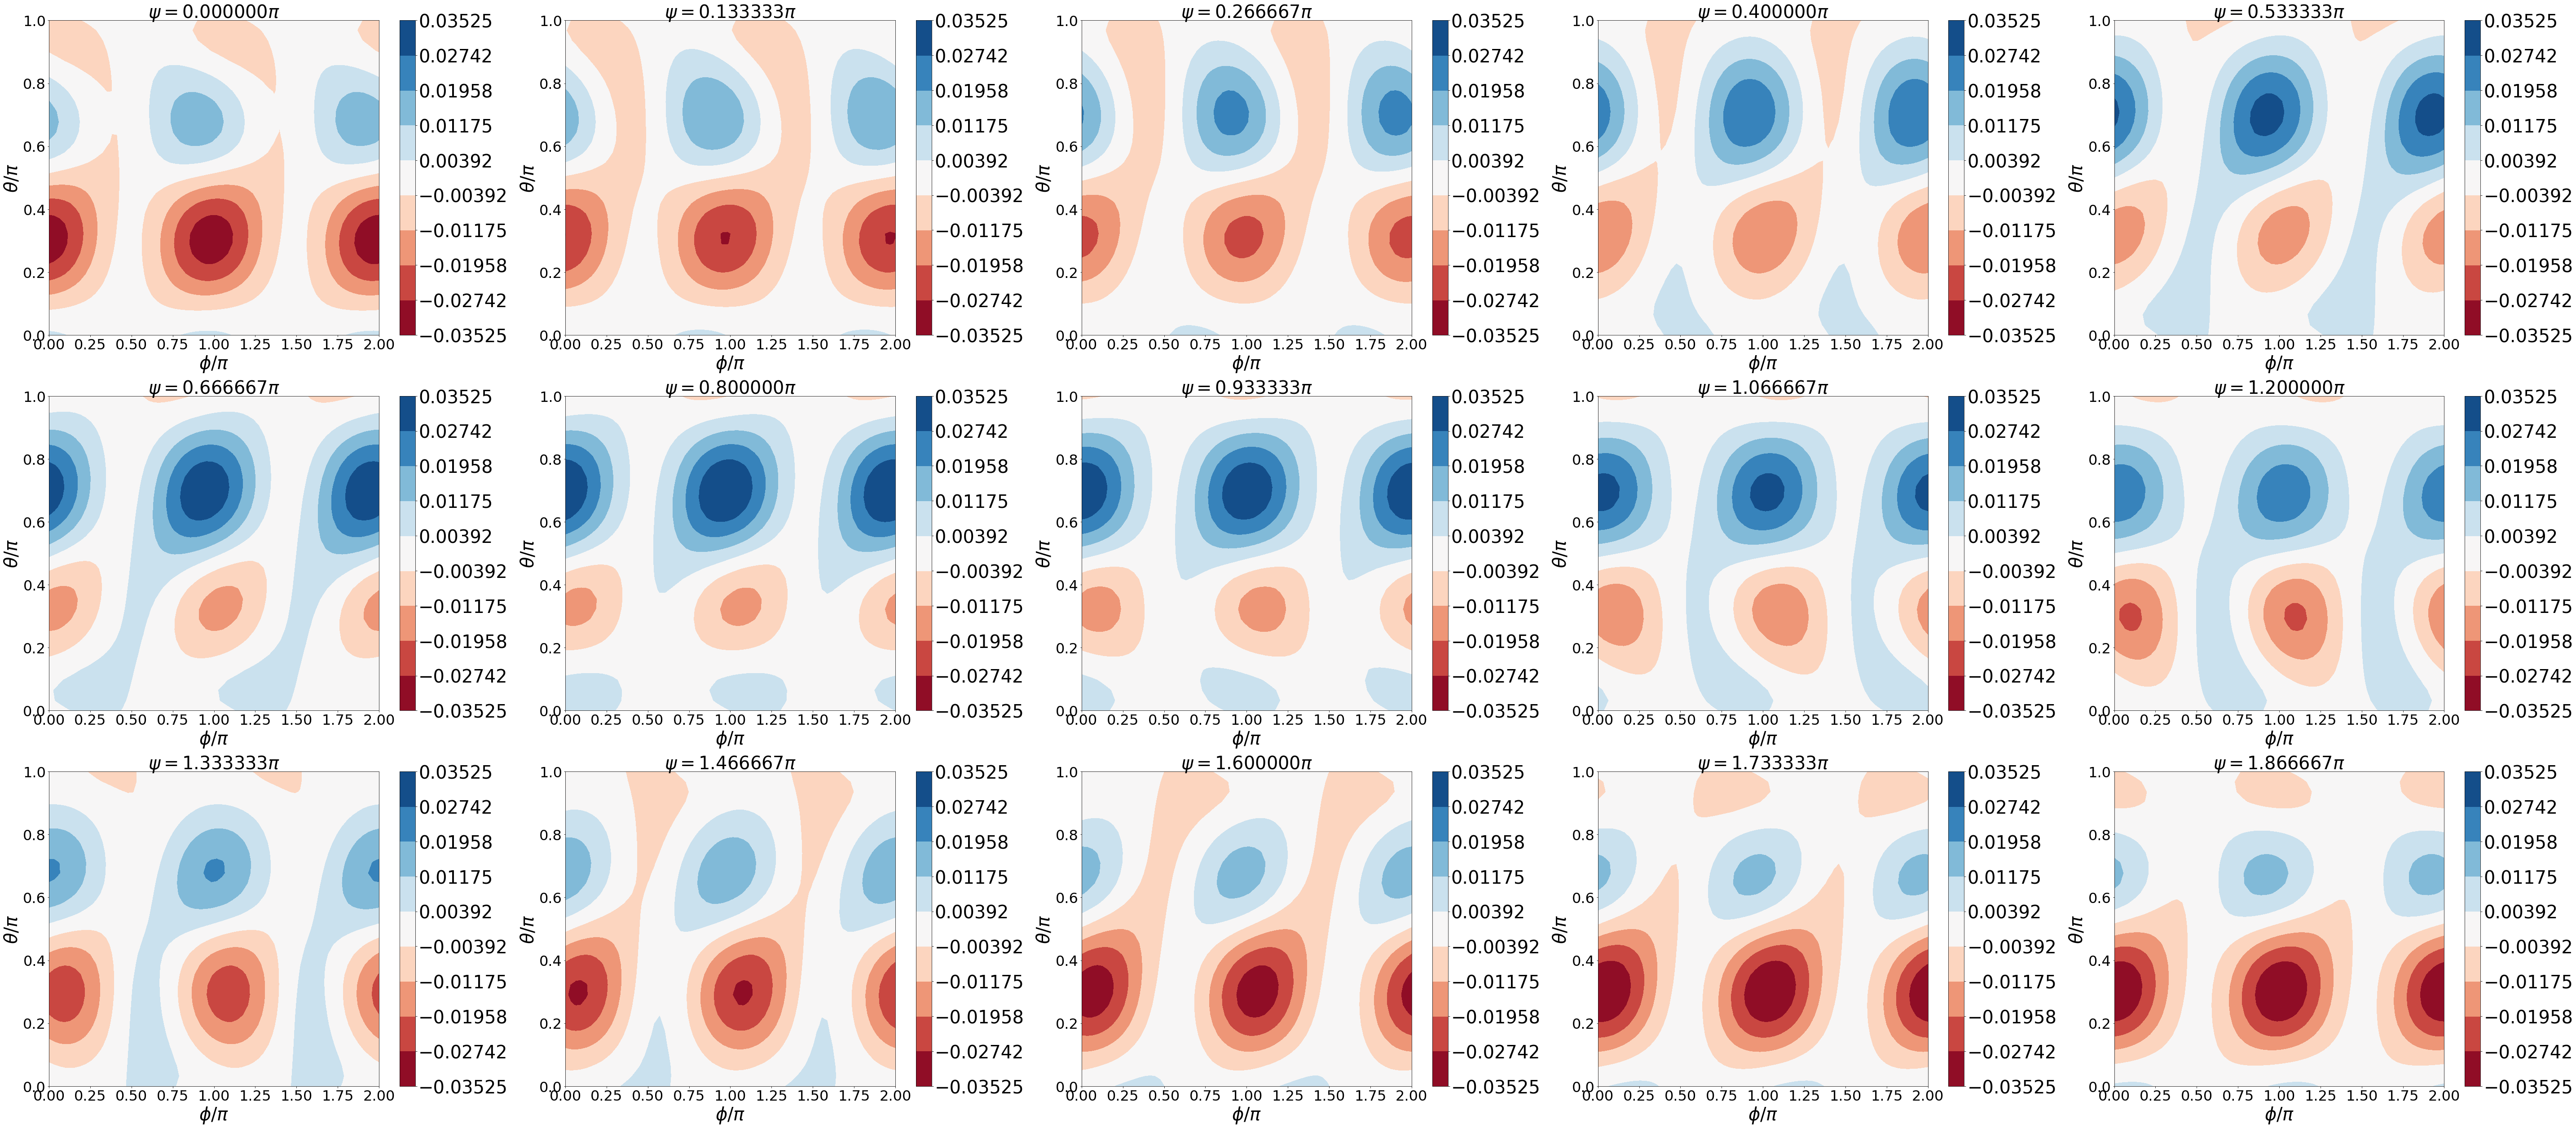

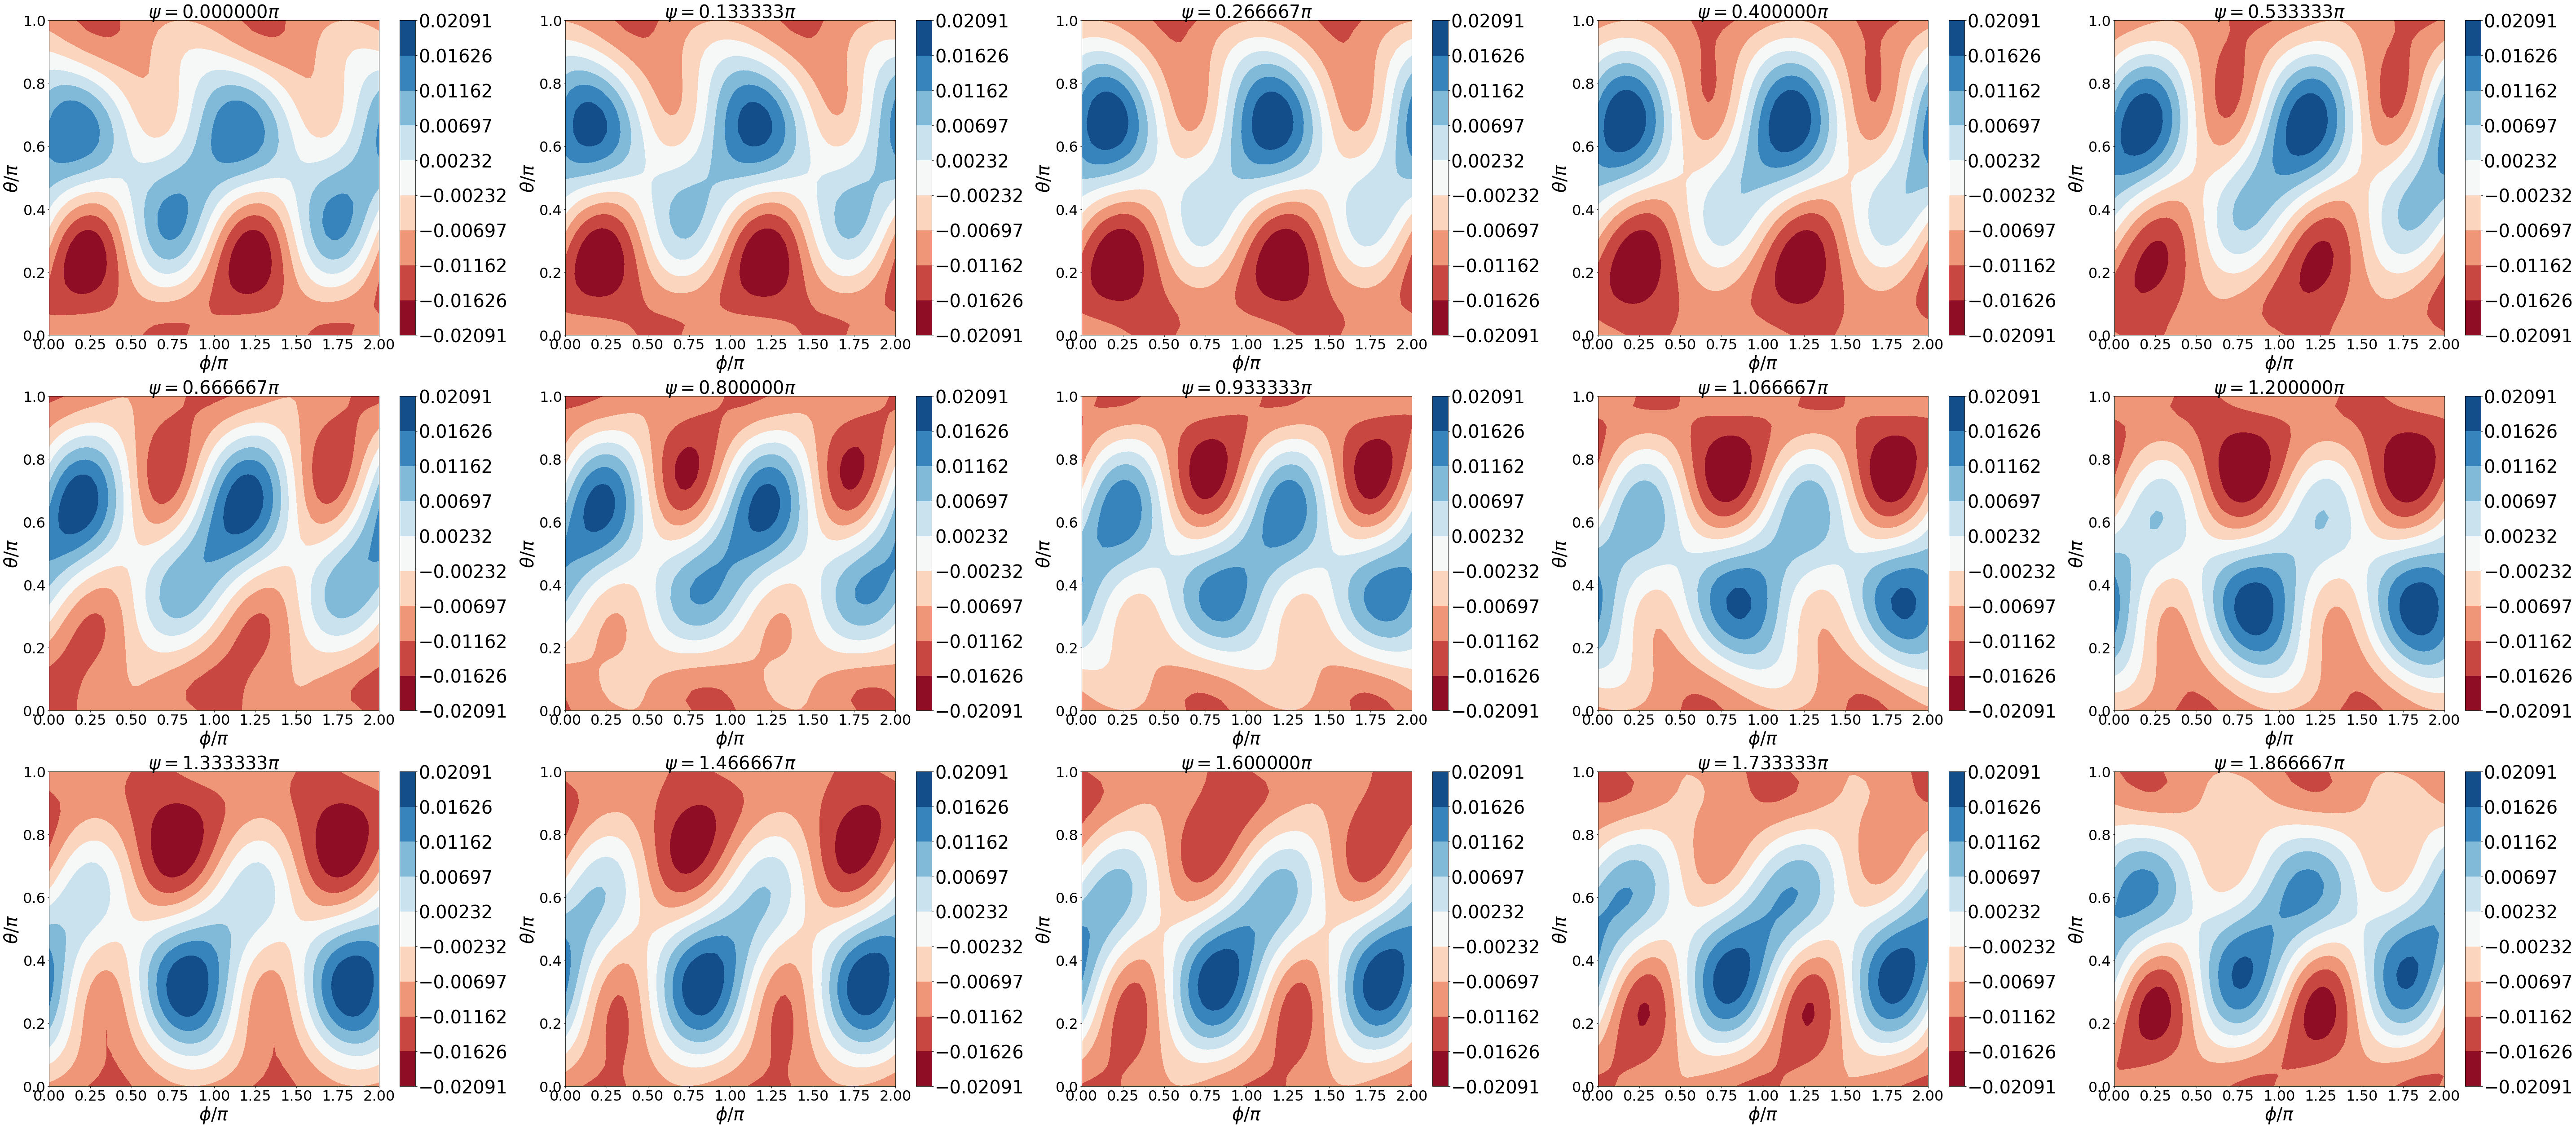

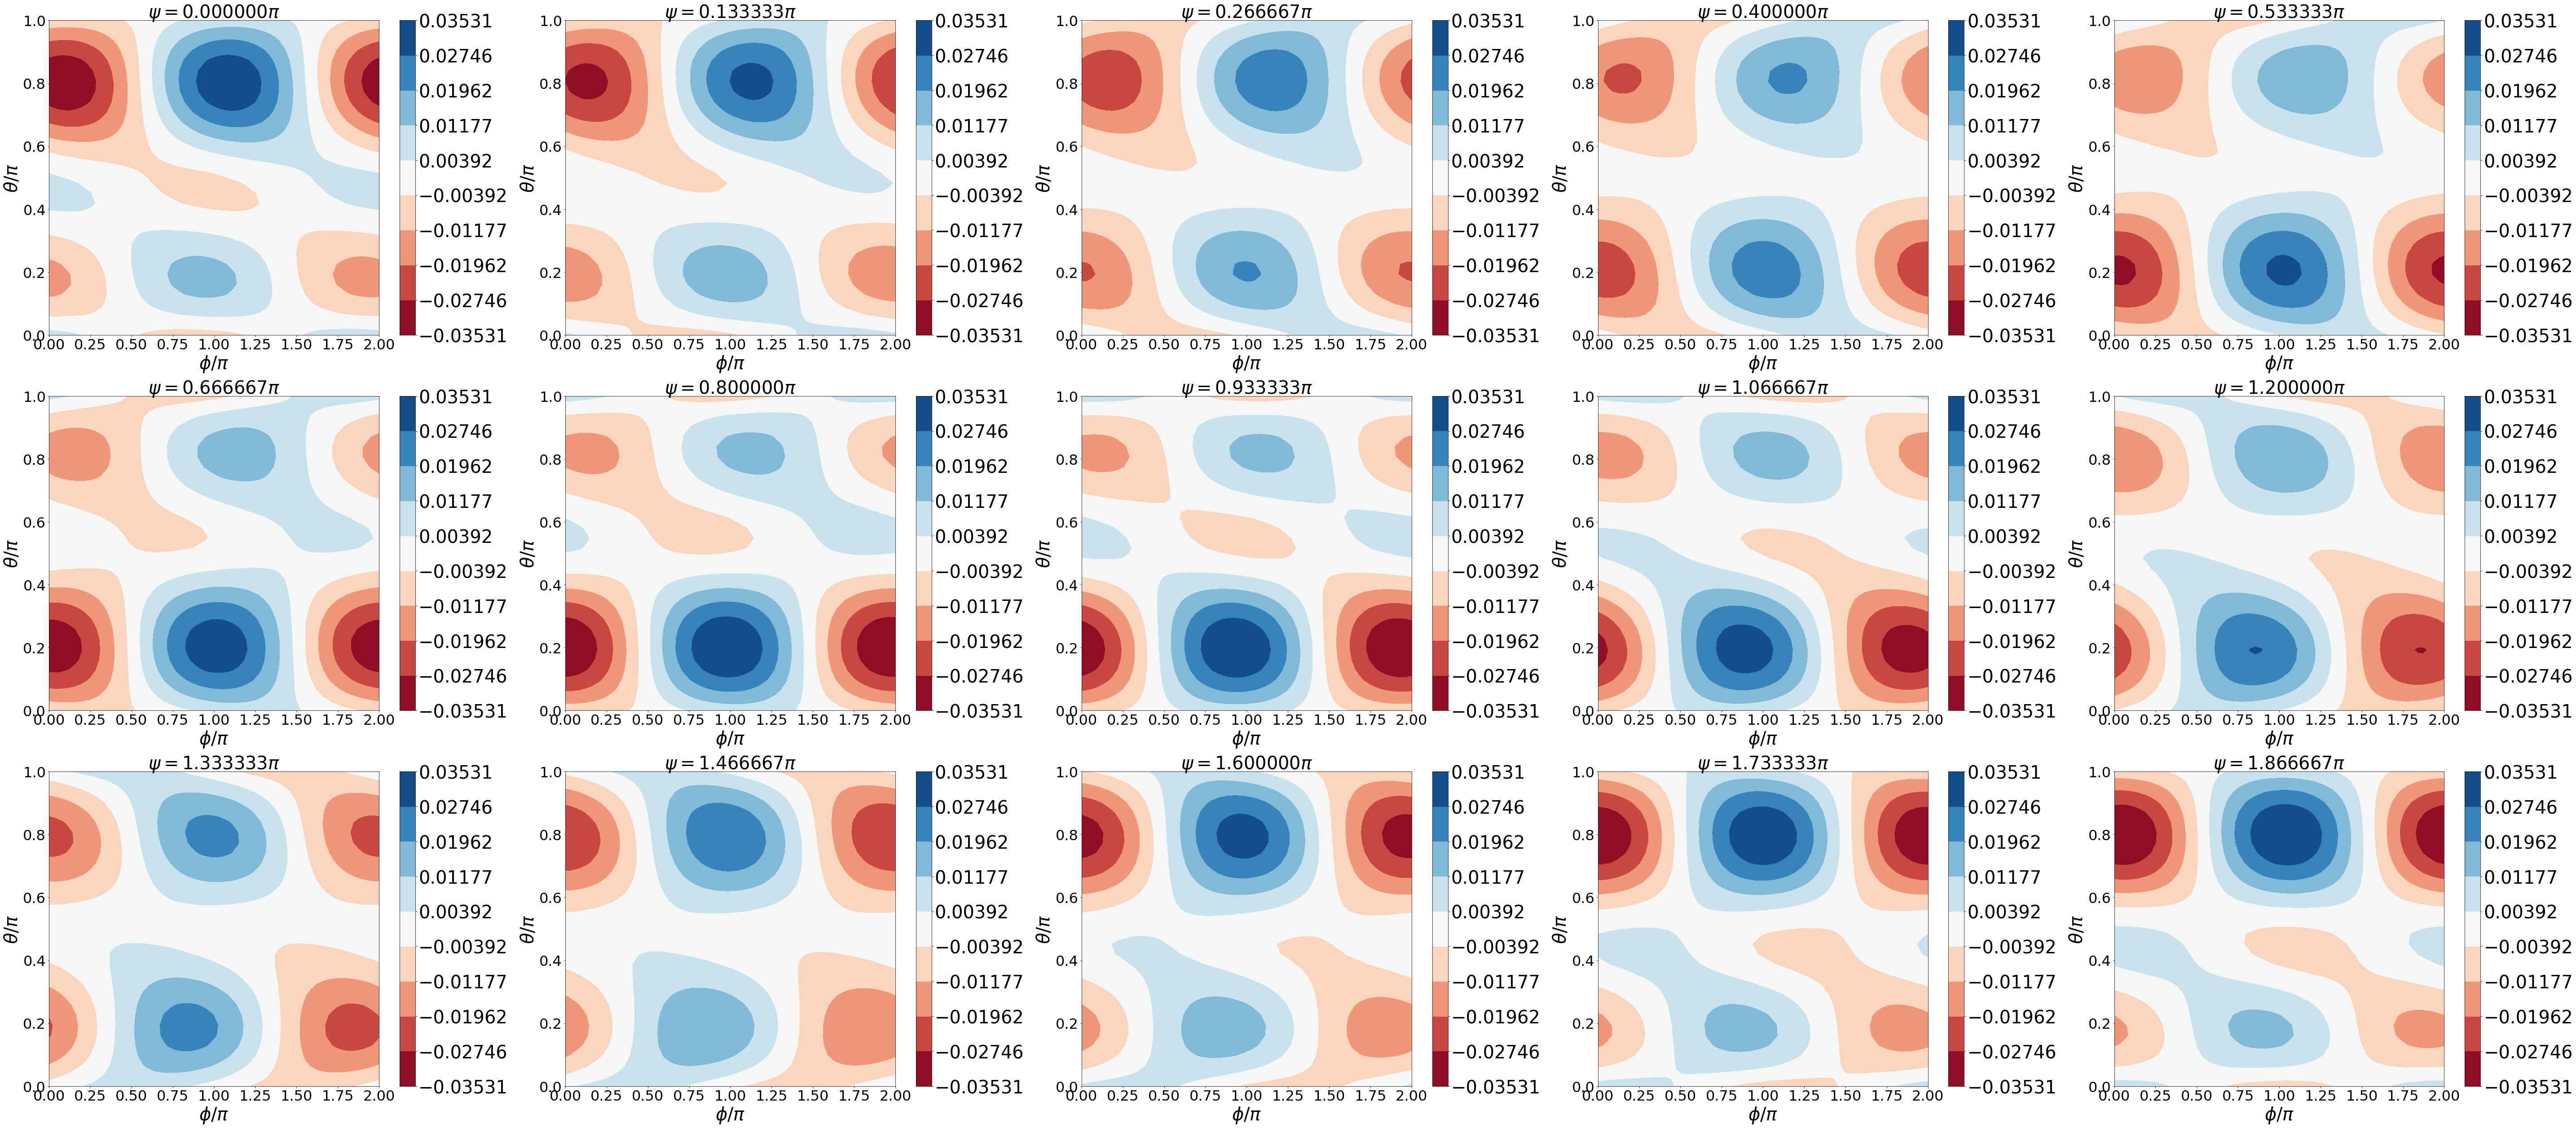

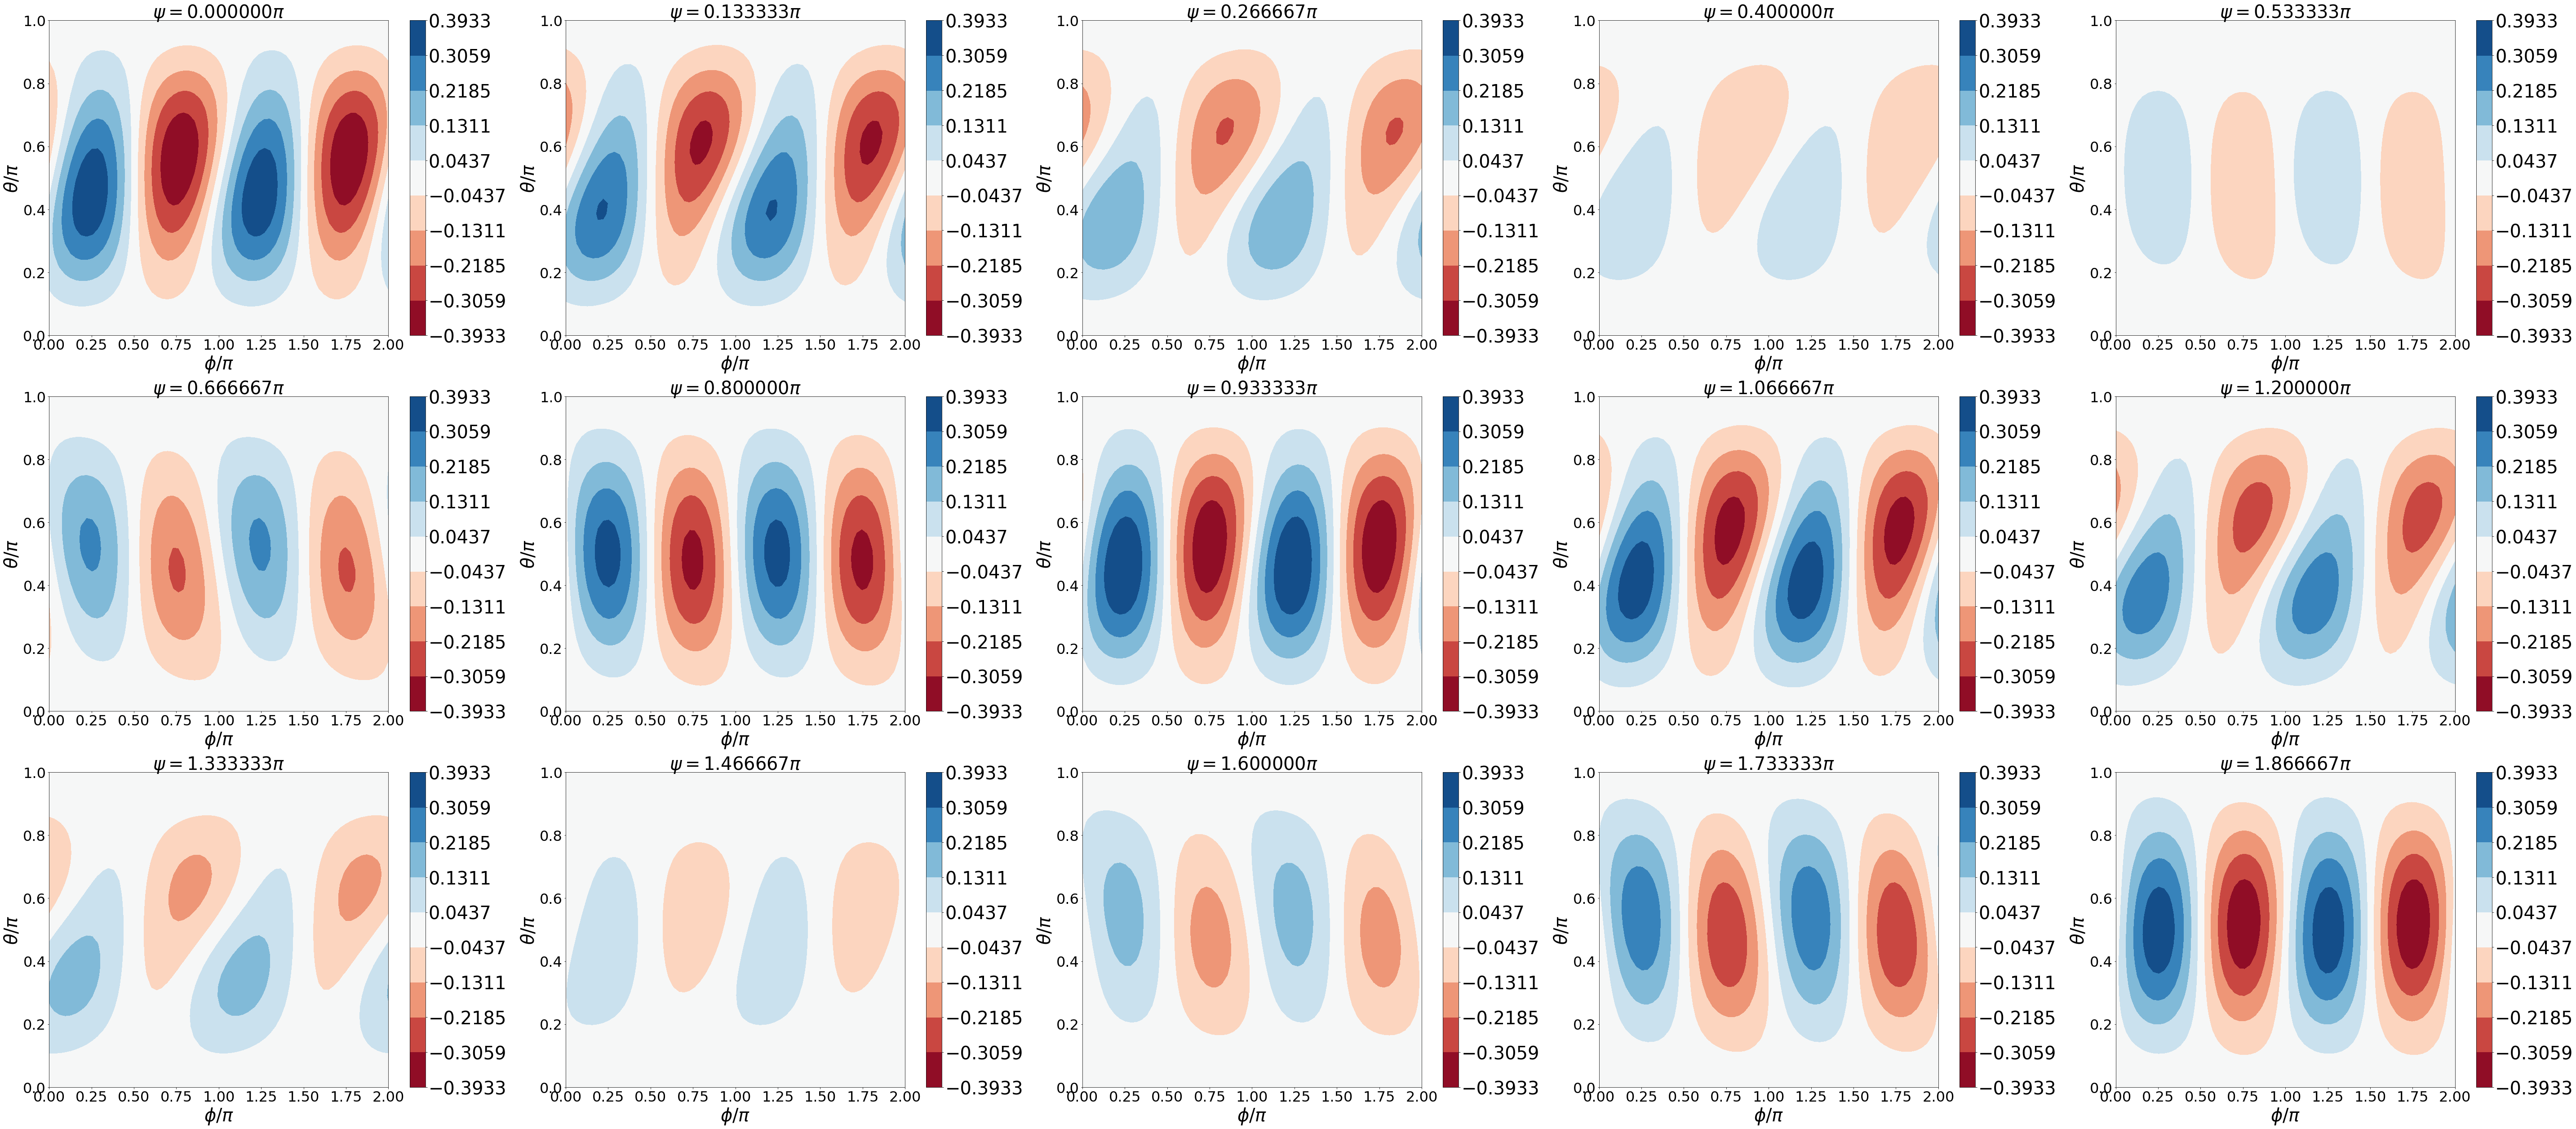

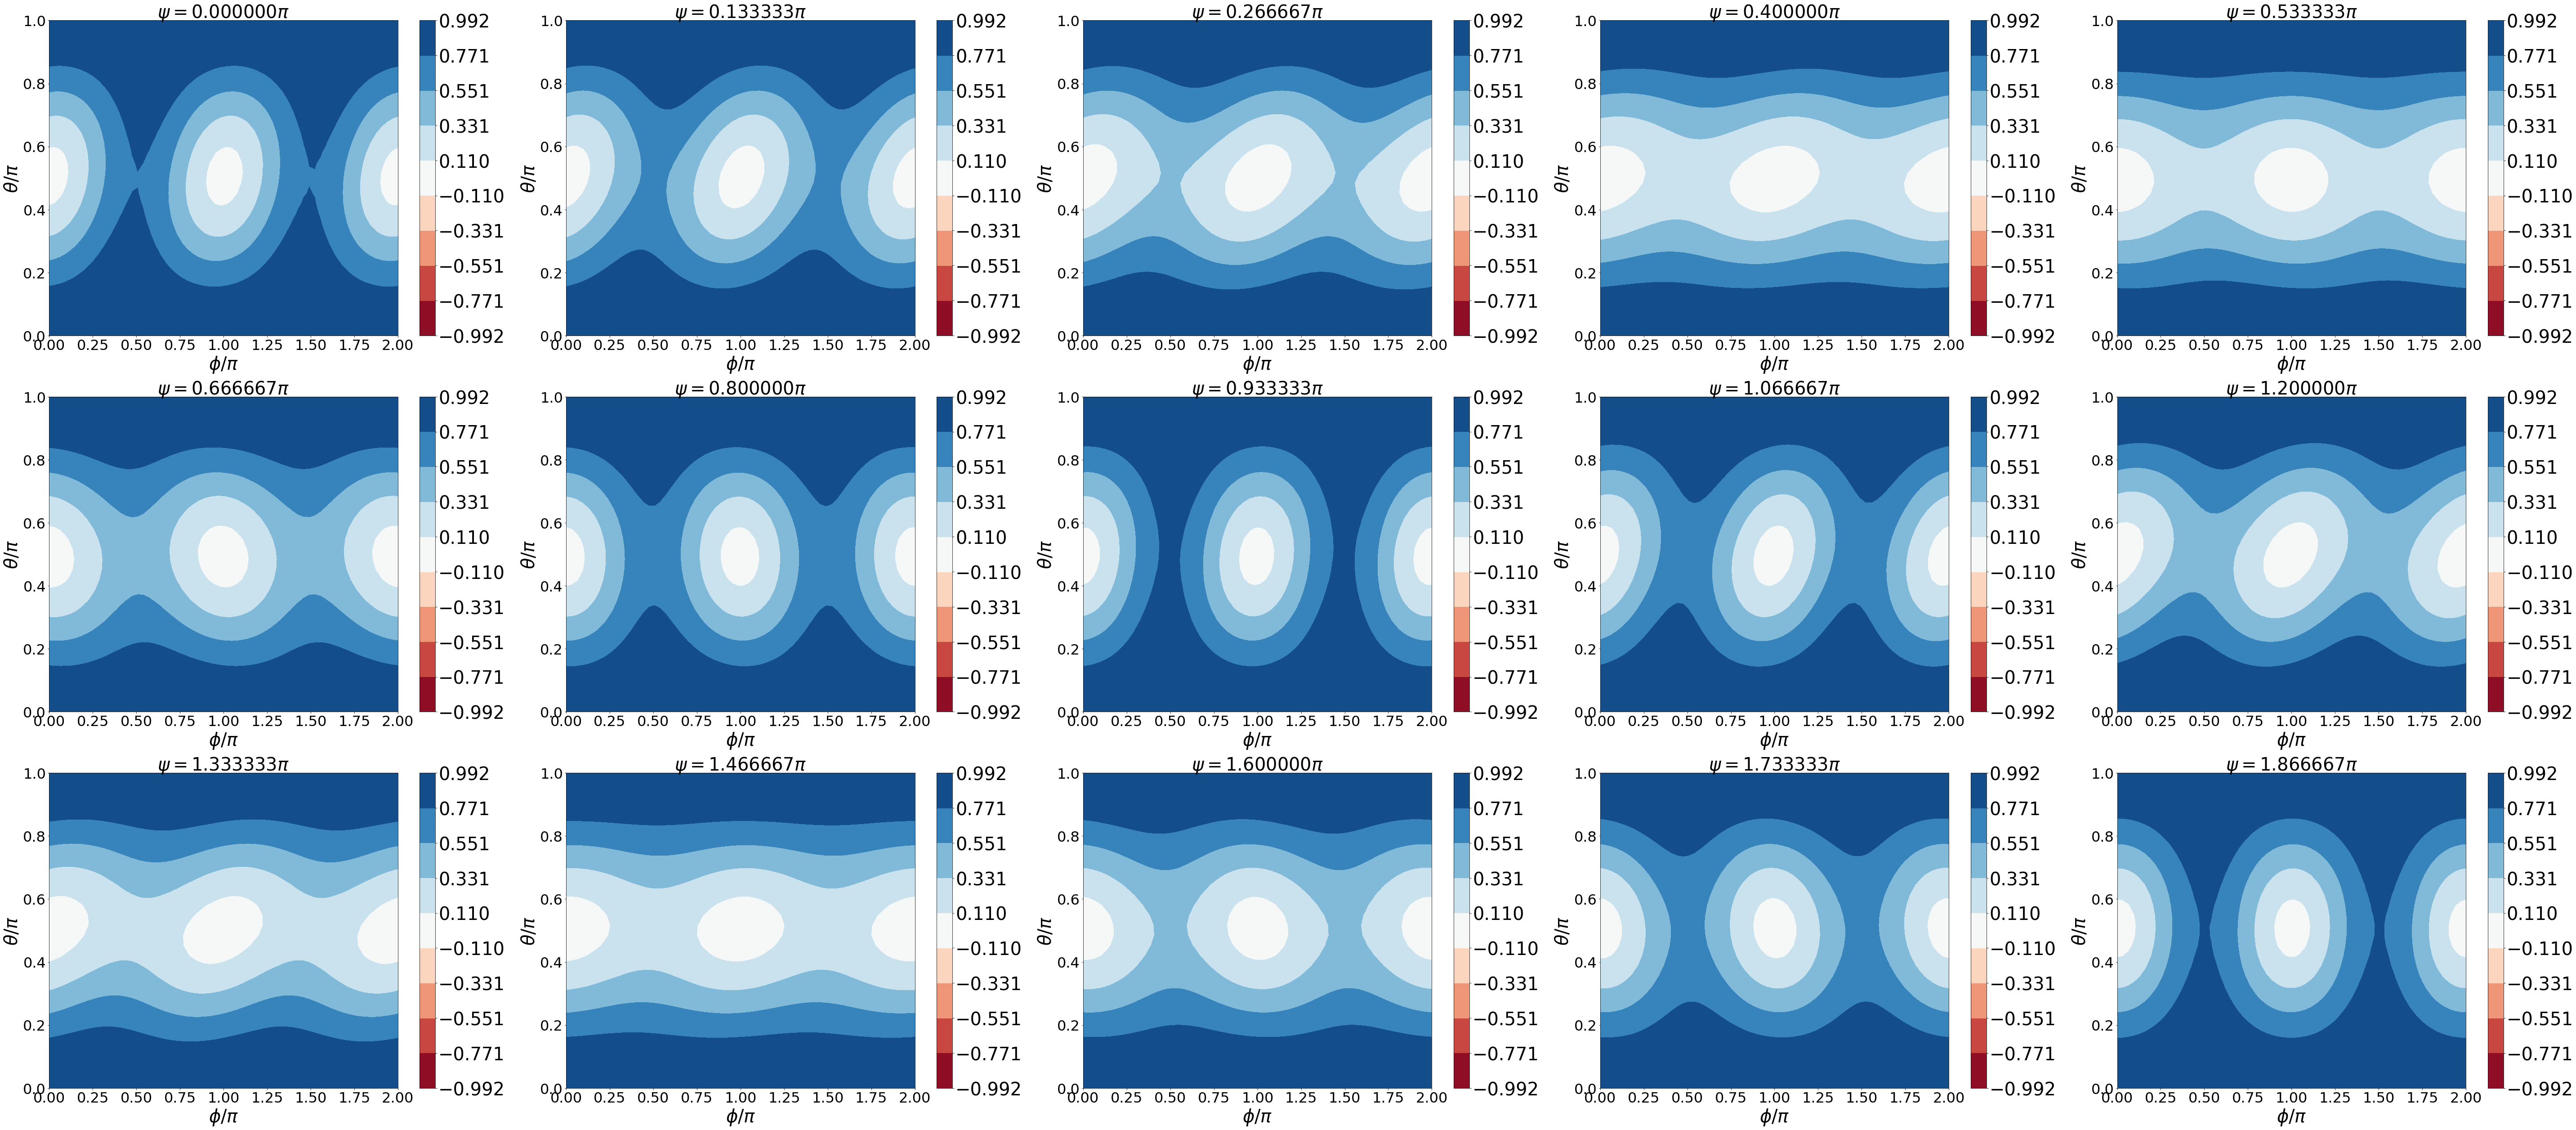

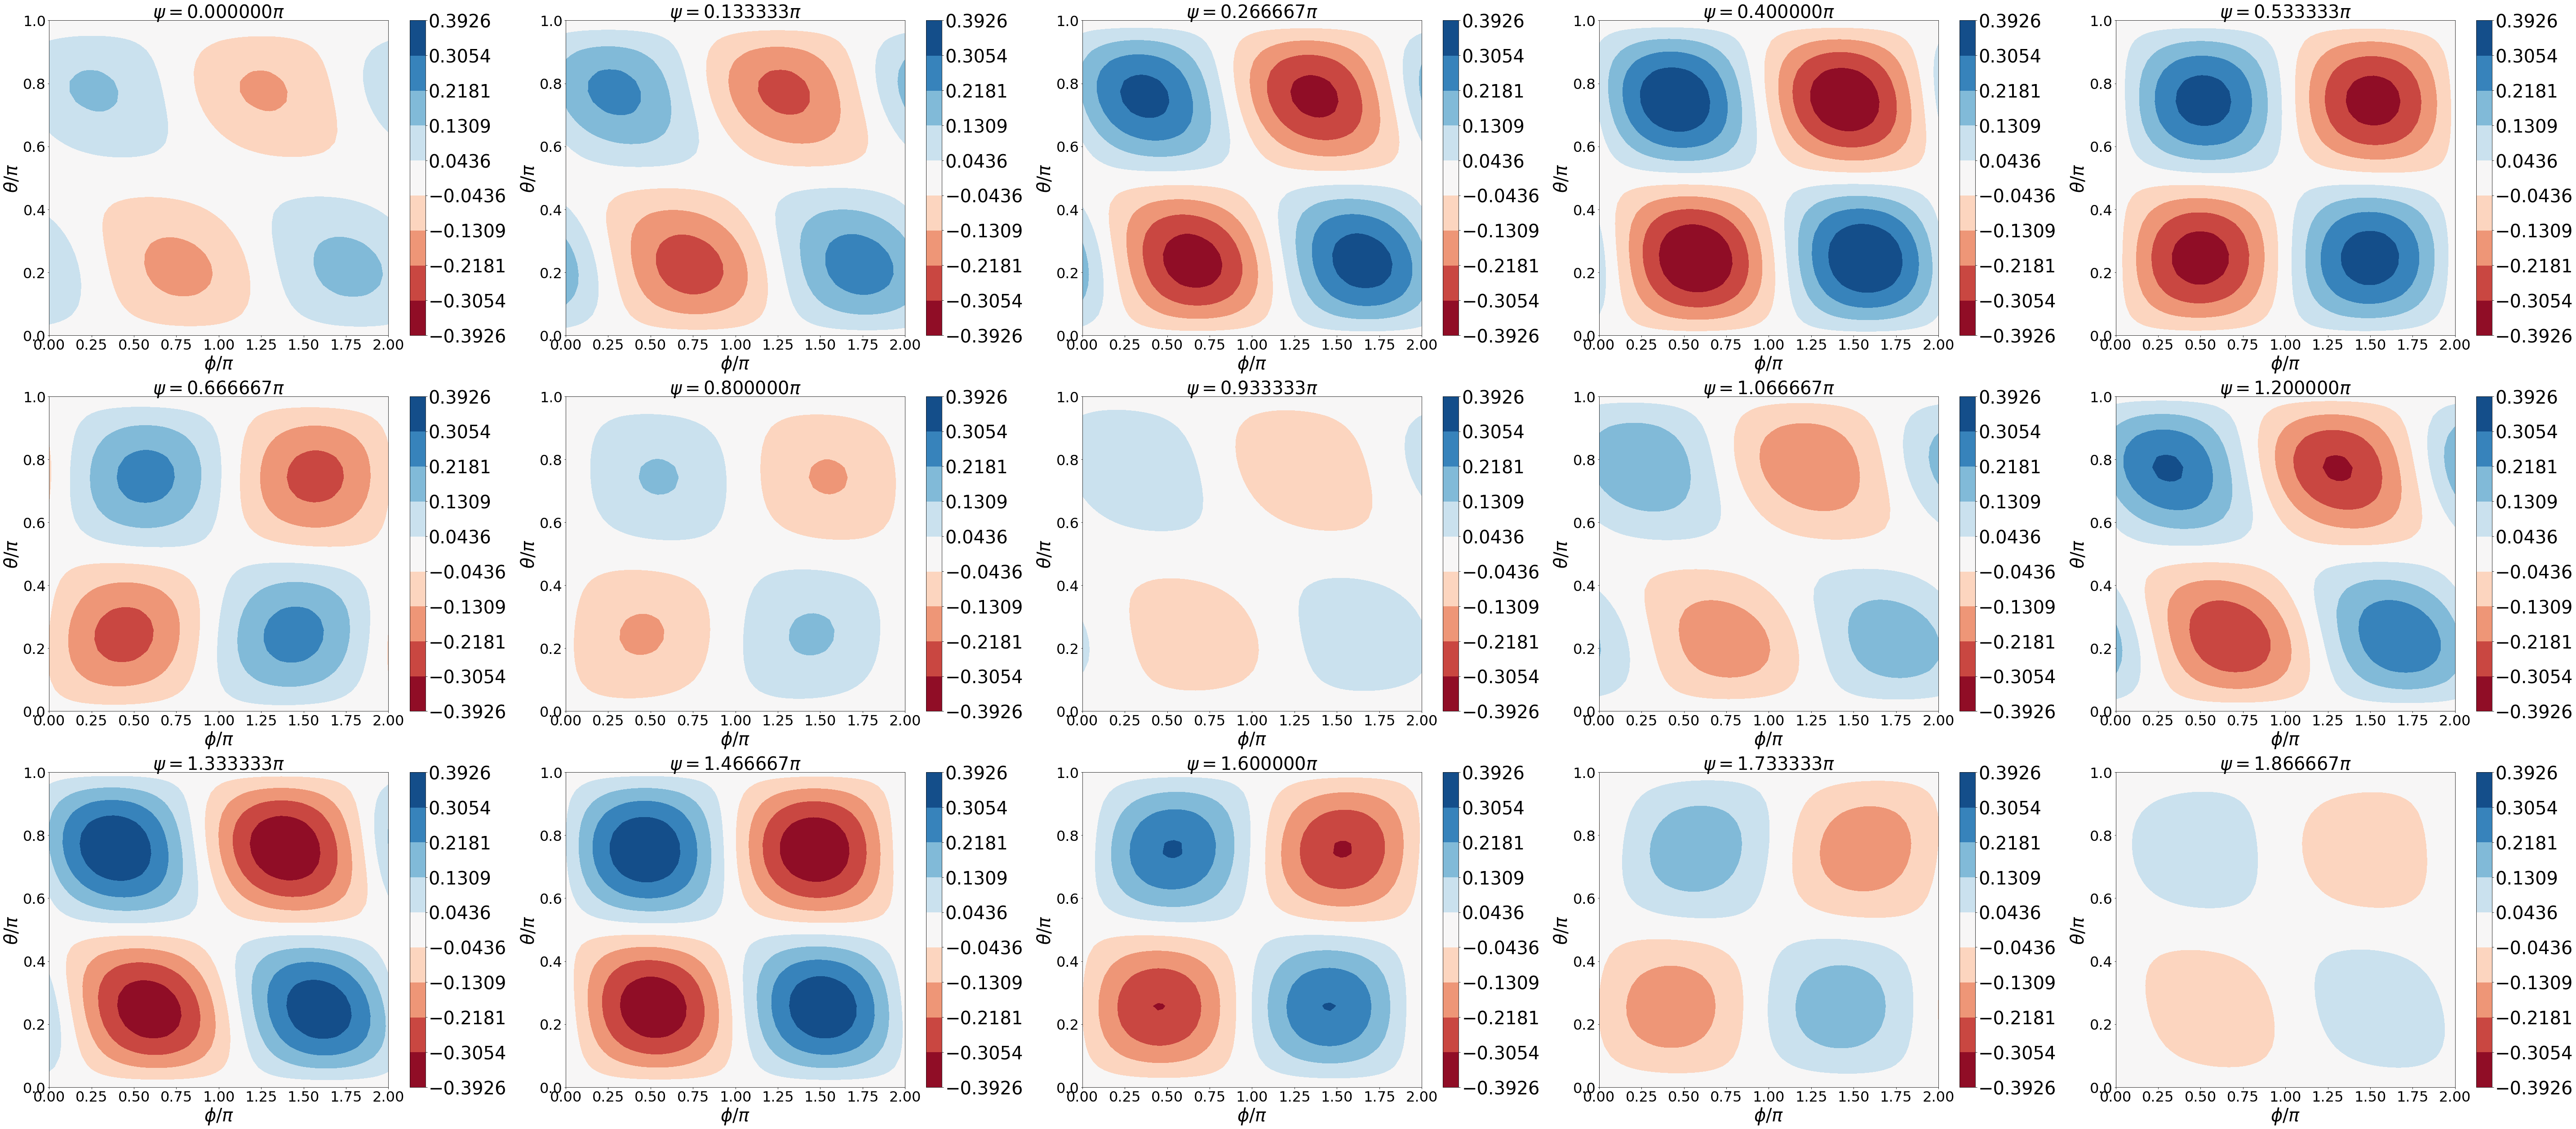

In [4]:
# show phase map of (ui, wi) as function of (theta, phi, psi)
job_dir = 'ecoC01B05_tau1c_passive'

print(job_dir)
with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)

U_all = [[] for i in range(6)]
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))

for Ui in U_all:
    t1 = []
    for _, _, _, tU in Ui:
        t1.append(np.nanmax(np.abs(tU.values)))
    t1 = np.nanmax(t1) 
    fig = plt.figure(figsize=(80, 35))
    fig.patch.set_facecolor('white')
    axs = fig.subplots(nrows=3, ncols=5)
    for (tpsi, ty, tx, use_U), ax0 in zip(Ui, axs.flatten()):
        levels = np.linspace(-t1, t1, 10)
        im = ax0.contourf(tx / np.pi, ty / np.pi, use_U.values, 
                          levels, cmap=plt.get_cmap('RdBu'))
        ax0.set_title('$\\psi=%f \pi$' % (tpsi / np.pi), fontsize=fontsize)
        ax0.set_xlabel('$\\phi / \pi$', fontsize=fontsize)
        ax0.set_ylabel('$\\theta / \pi$', fontsize=fontsize)
        fig.colorbar(im, ax=ax0, orientation='vertical').ax.tick_params(labelsize=fontsize)
        plt.sca(ax0)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()

In [ ]:
# show phase map of (ui, wi) as function of (theta, phi, psi) in polar coordinate. 
# job_dir = 'ecoC01B00_T-0.111'

print(job_dir, 'polar')
with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)

U_all = [[] for i in range(6)]
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))

for Ui in U_all[:]:
    t1 = []
    for _, _, _, tU in Ui:
        t1.append(np.nanmax(np.abs(tU.values)))
    t1 = np.nanmax(t1) 
    fig = plt.figure(figsize=(80, 35))
    fig.patch.set_facecolor('white')
    axs = fig.subplots(nrows=3, ncols=5, subplot_kw=dict(polar=True))
    for (tpsi, ty, tx, use_U), ax0 in zip(Ui[:], axs.flatten()):
        levels = np.linspace(-t1, t1, 10)
        im = ax0.contourf(tx, ty, use_U.values, 
                          levels, cmap=plt.get_cmap('RdBu'))
        fig.colorbar(im, ax=ax0, orientation='vertical').ax.tick_params(labelsize=fontsize)
        ax0.set_title('$\\psi=%f \pi$' % (tpsi / np.pi), fontsize=fontsize)
        n_xticks = 8
        xticks = np.arange(n_xticks)
        ax0.set_xticks(xticks / n_xticks * 2 * np.pi)
        ax0.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
        ax0.set_yticklabels([])
        ax0.set_ylim(0, np.pi)
        plt.sca(ax0)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()

In [188]:
axi

ecoC01B05_T10


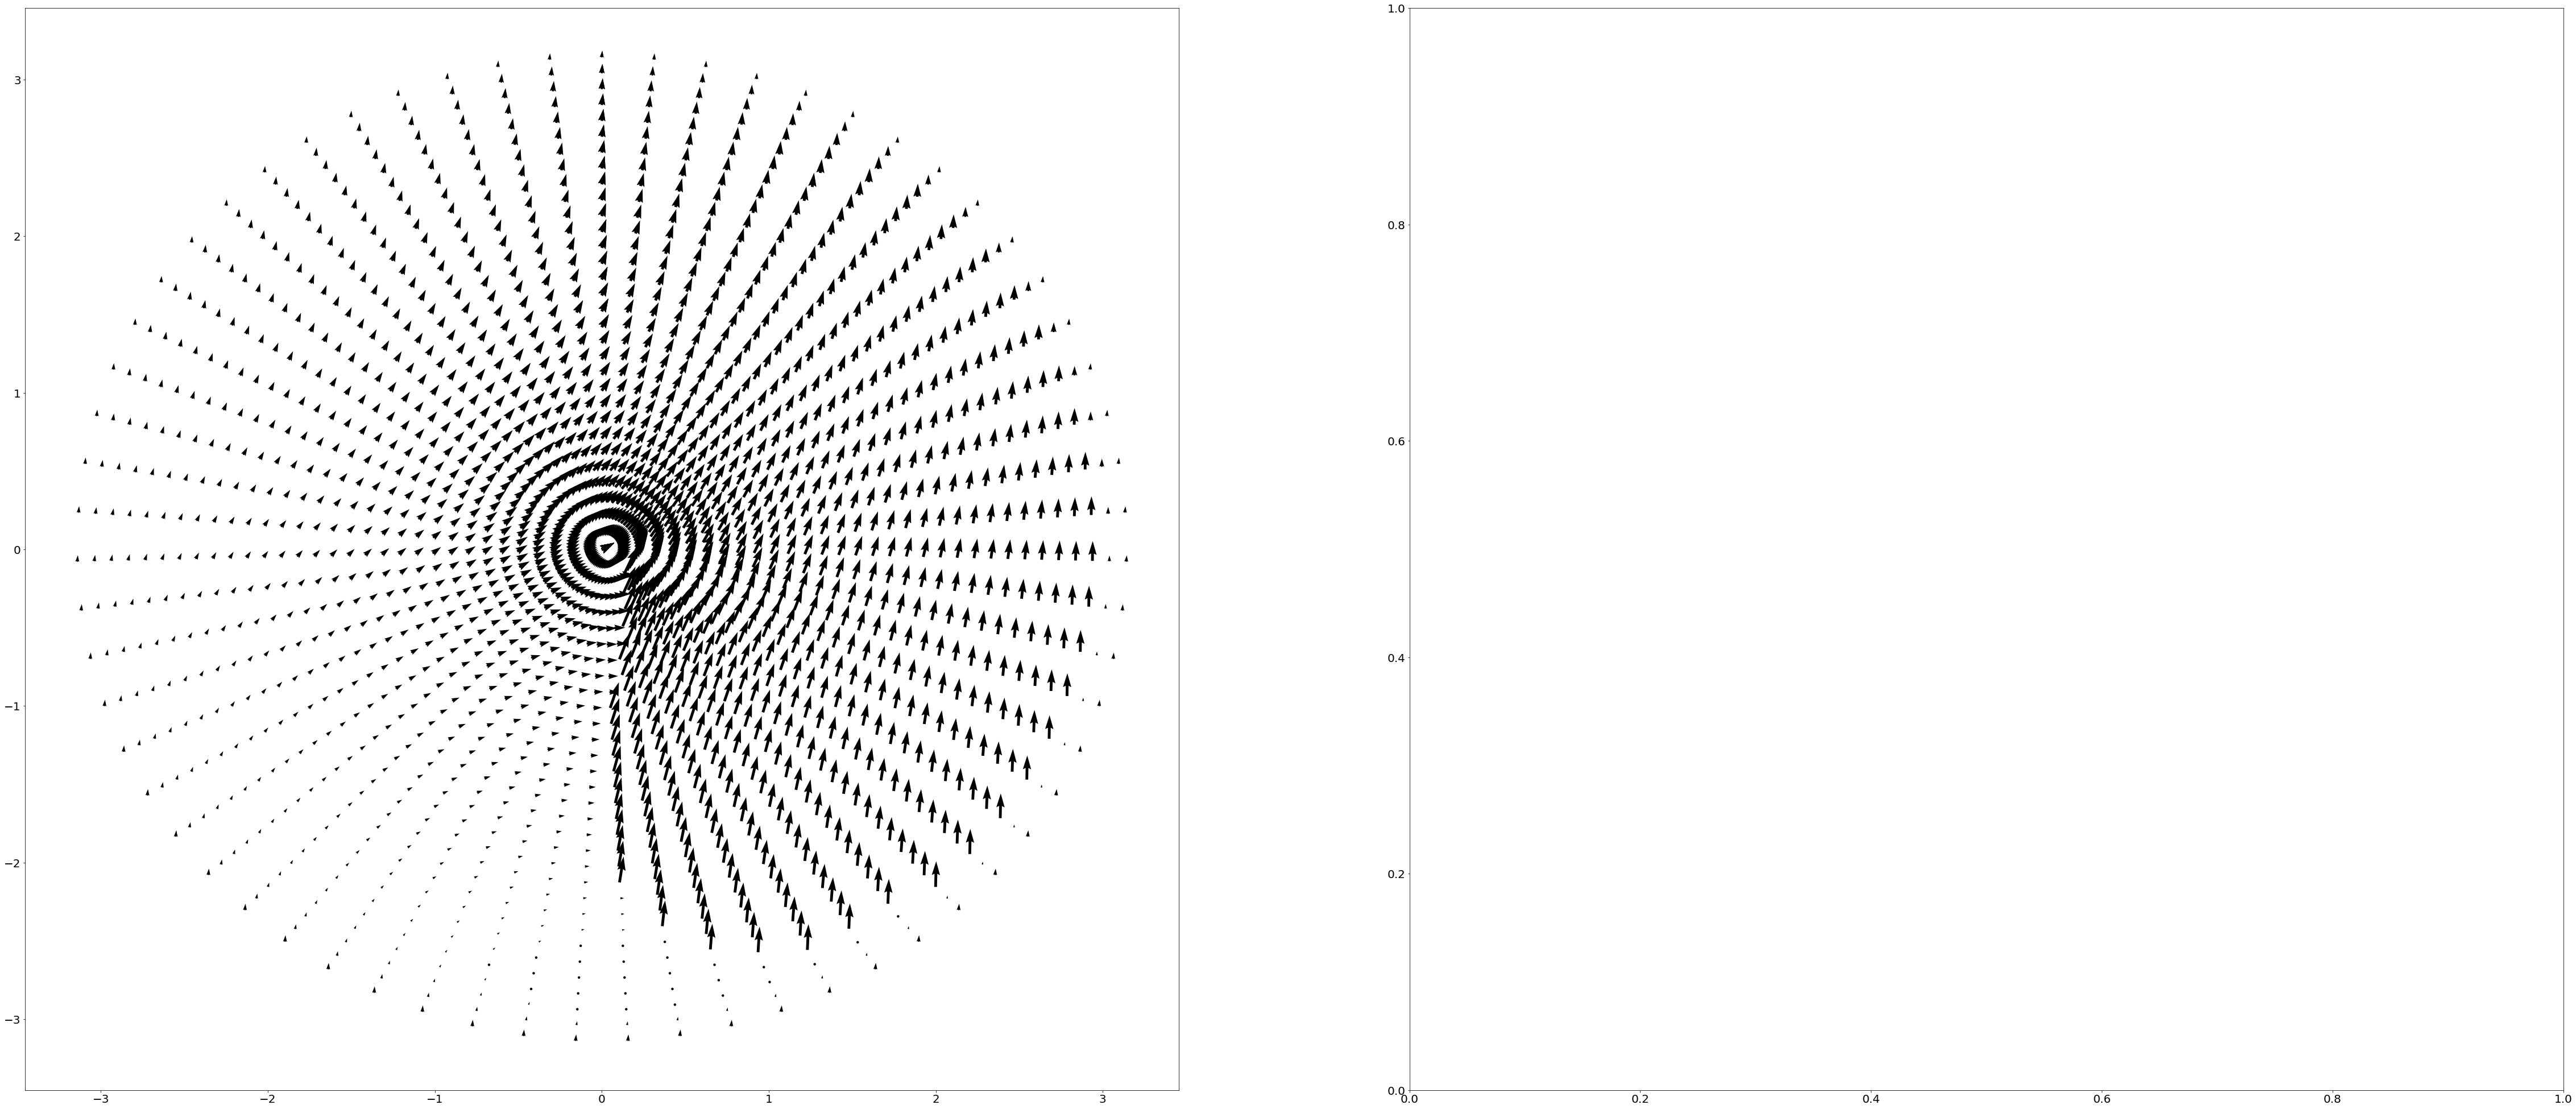

In [204]:
job_dir = 'ecoC01B05_T10'
# job_dir = 'ecoC01B05_tau1c_passive'

print(job_dir)
with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)
U_all = [[] for i in range(6)]
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))
Wx_data = U_all[3]
Wy_data = U_all[4]

fig = plt.figure(figsize=(80, 35))
fig.patch.set_facecolor('white')
# axs = fig.subplots(nrows=3, ncols=5, subplot_kw=dict(polar=True))
# axs = fig.subplots(nrows=3, ncols=5)
axs = fig.subplots(nrows=1, ncols=2)
for axi, twx_data, twy_data, twz_data in zip(axs.flatten()[:1], U_all[3], U_all[4], U_all[5]):
    tpsi_x, _, _, tWx = twx_data 
    tpsi_y, _, _, tWy = twy_data 
    tpsi_z, _, _, tWz = twz_data
    _, ty, tx, _ = twx_data
    tx, ty = np.meshgrid(tx, ty)
    t_norm = np.sqrt((tWx ** 2 + tWy ** 2 + tWz ** 2))
    ttheta = np.arccos(tWz / t_norm).values
    tphi = np.arctan2(tWy, tWx).values
    tphi[tphi < 0] = tphi[tphi < 0] + 2 * np.pi
    axi.quiver(ty * np.sin(tx), ty * np.cos(tx), ttheta, tphi)
#     axi.quiver(tx[::3, ::2], ty[::3, ::2], tWx.values[::3, ::2], tWy.values[::3, ::2], scale=10)
    


# tth = np.arctan2(Wy_data) 


In [202]:
tphi = np.arctan2(tWy, tWx).values
tphi[tphi < 0] = tphi[tphi < 0] + 2 * np.pi
tphi.max()

2.757670534962531

In [62]:
for Ui, u_avr_i in zip(U_all, U_avr):
    t1 = []
    for _, _, _, tU in Ui:
        t1.append(np.nanmax(np.abs((tU-u_avr_i).values)))
    t1 = np.nanmax(t1) 
print(t1)

0.3705168647412424


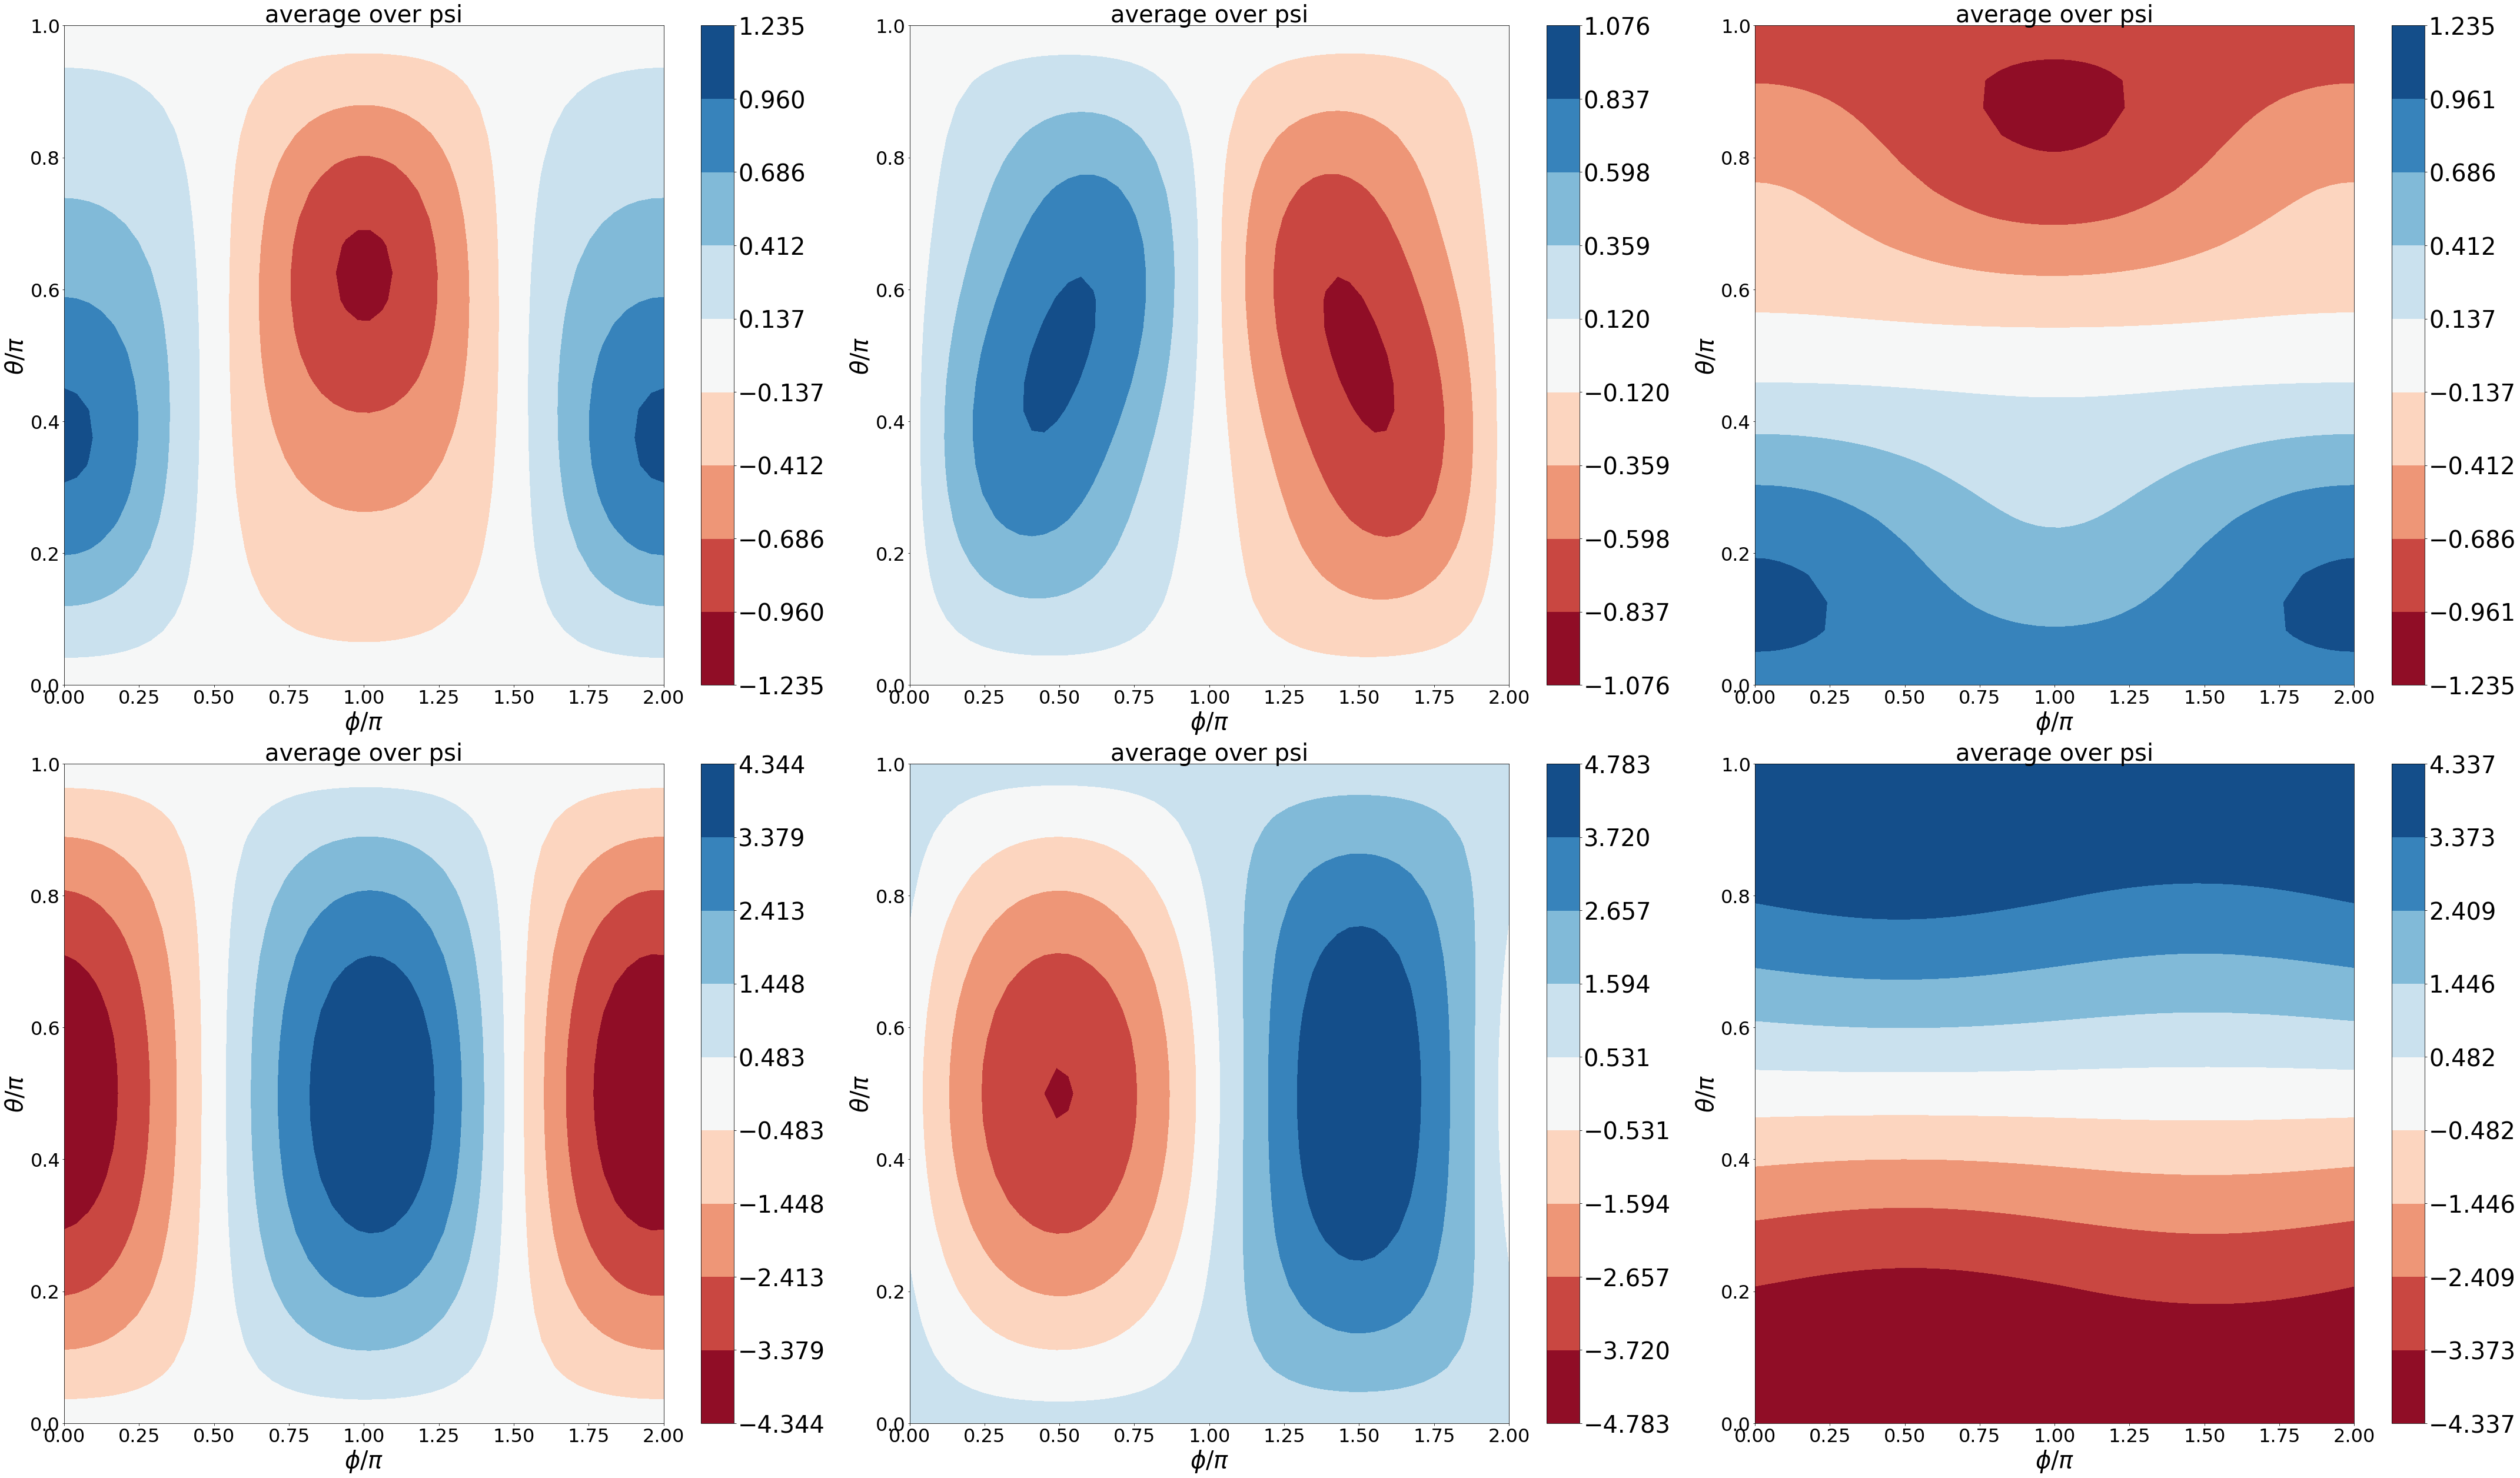

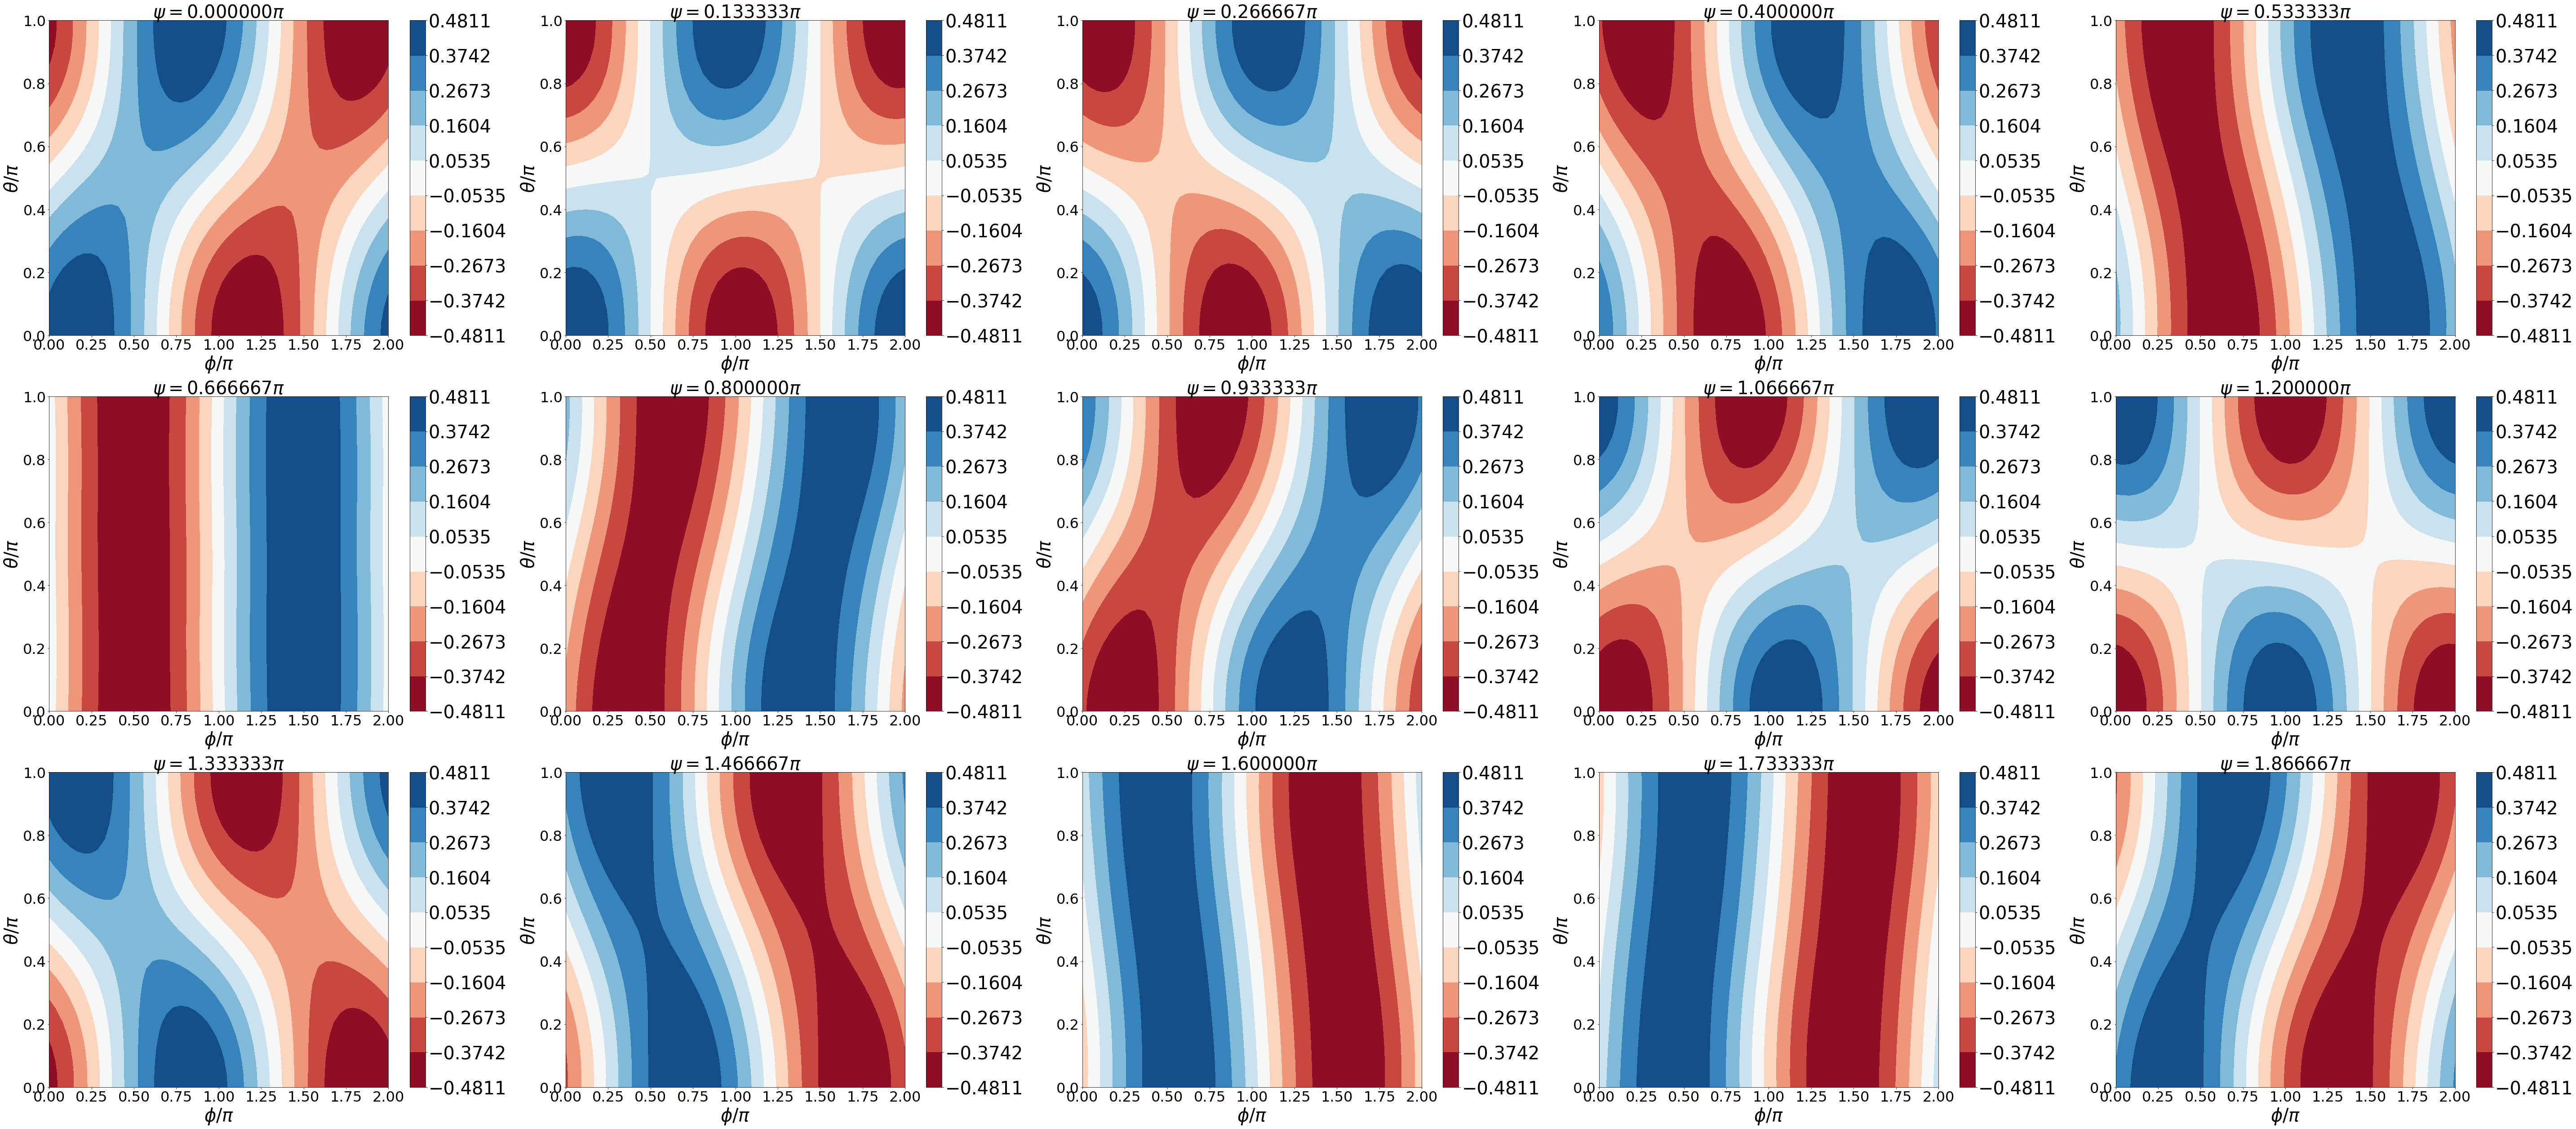

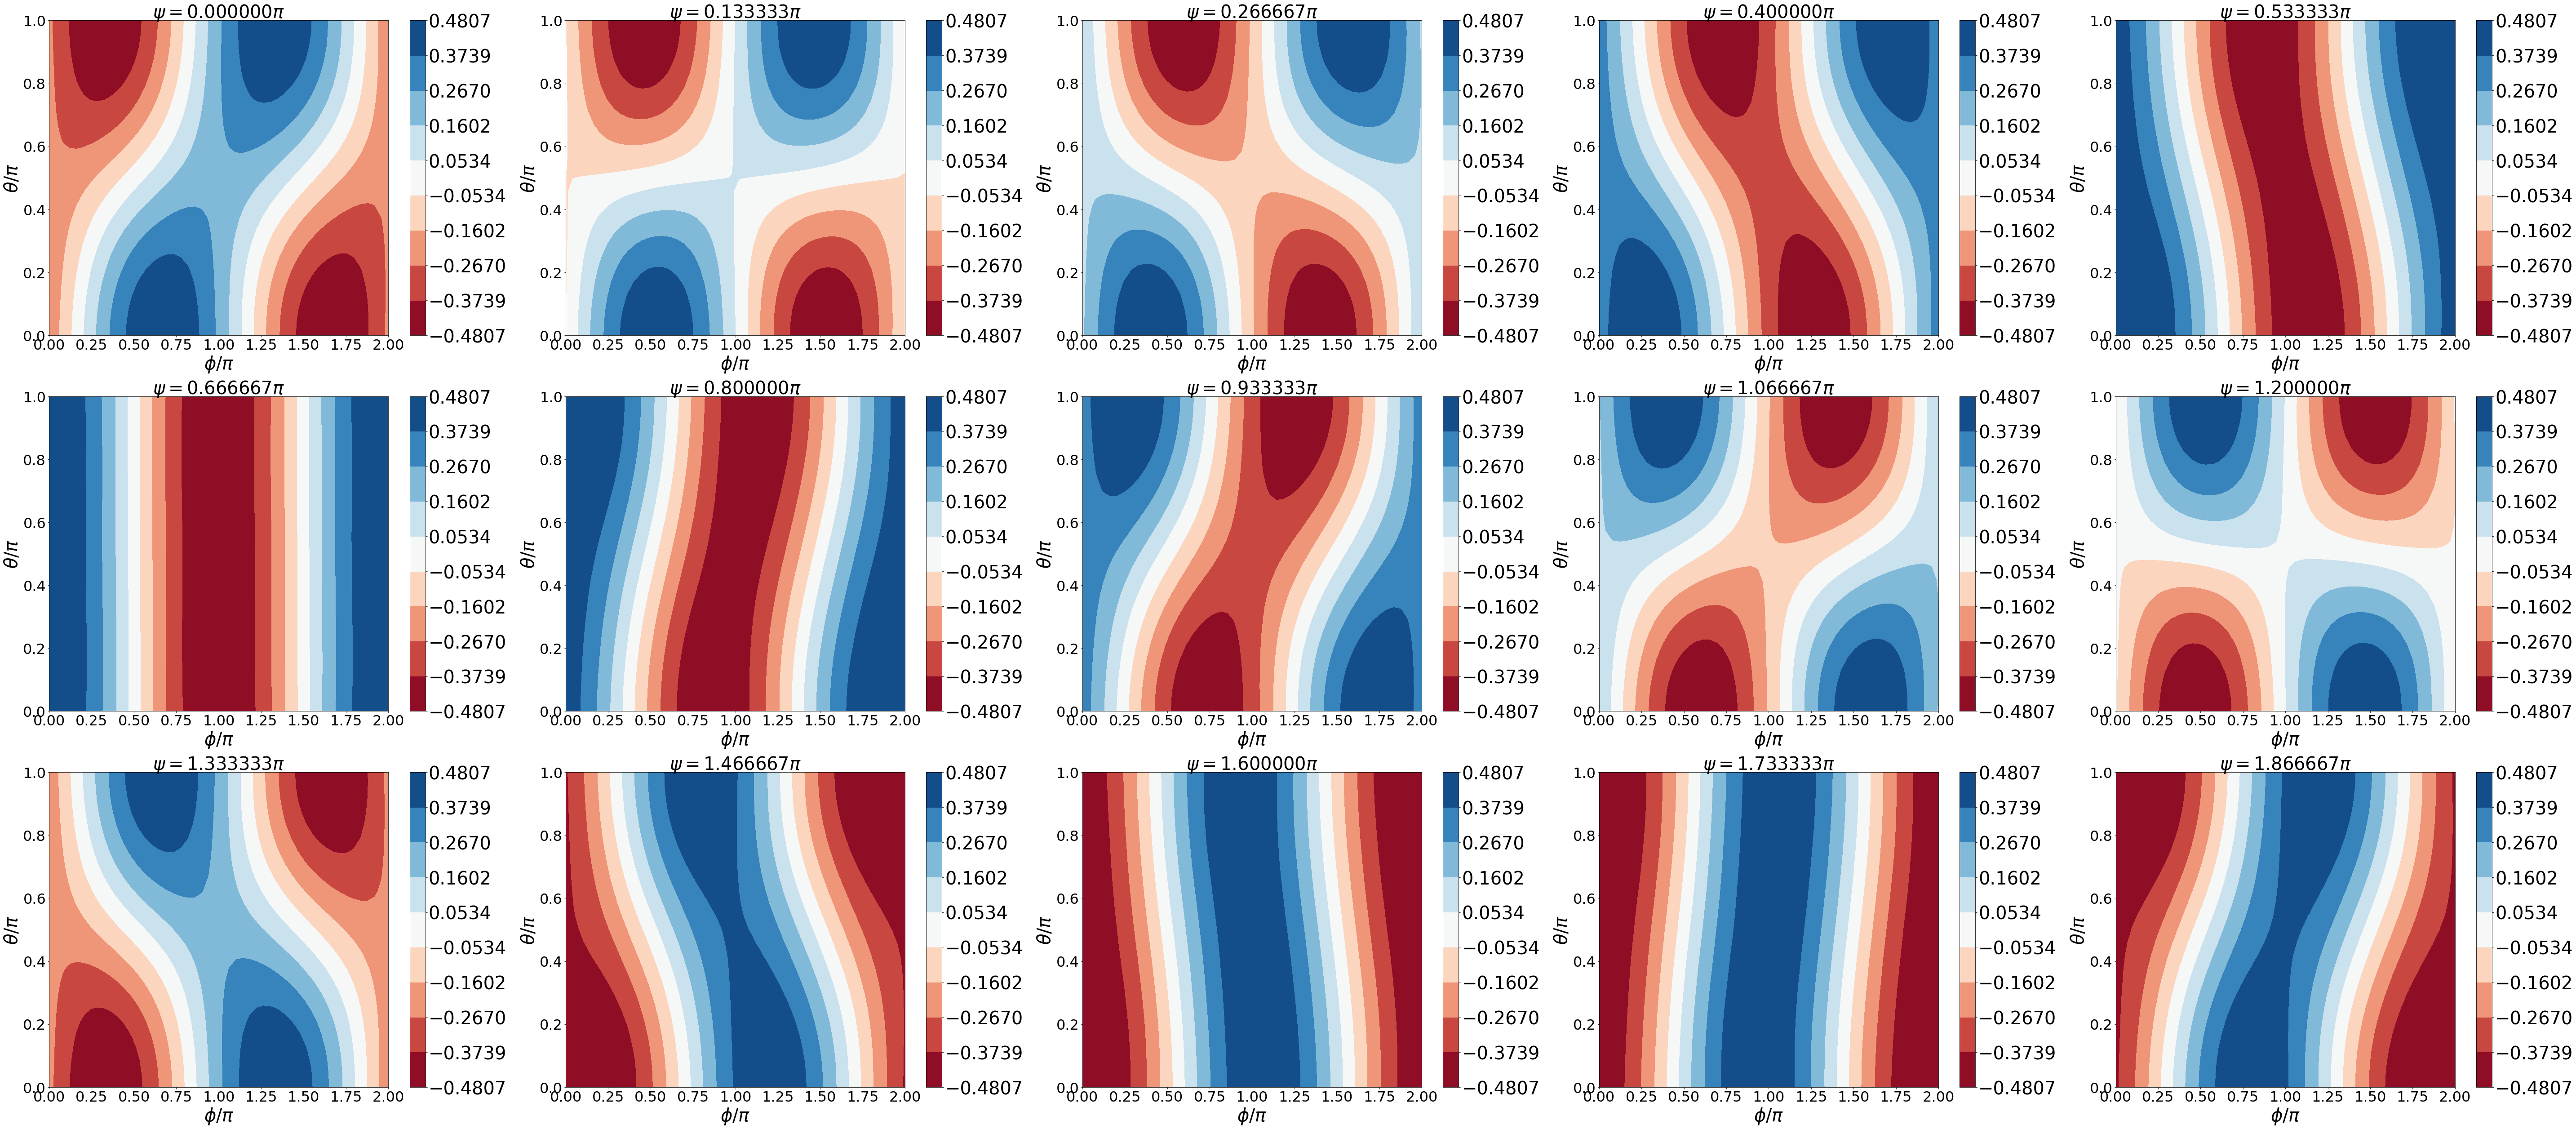

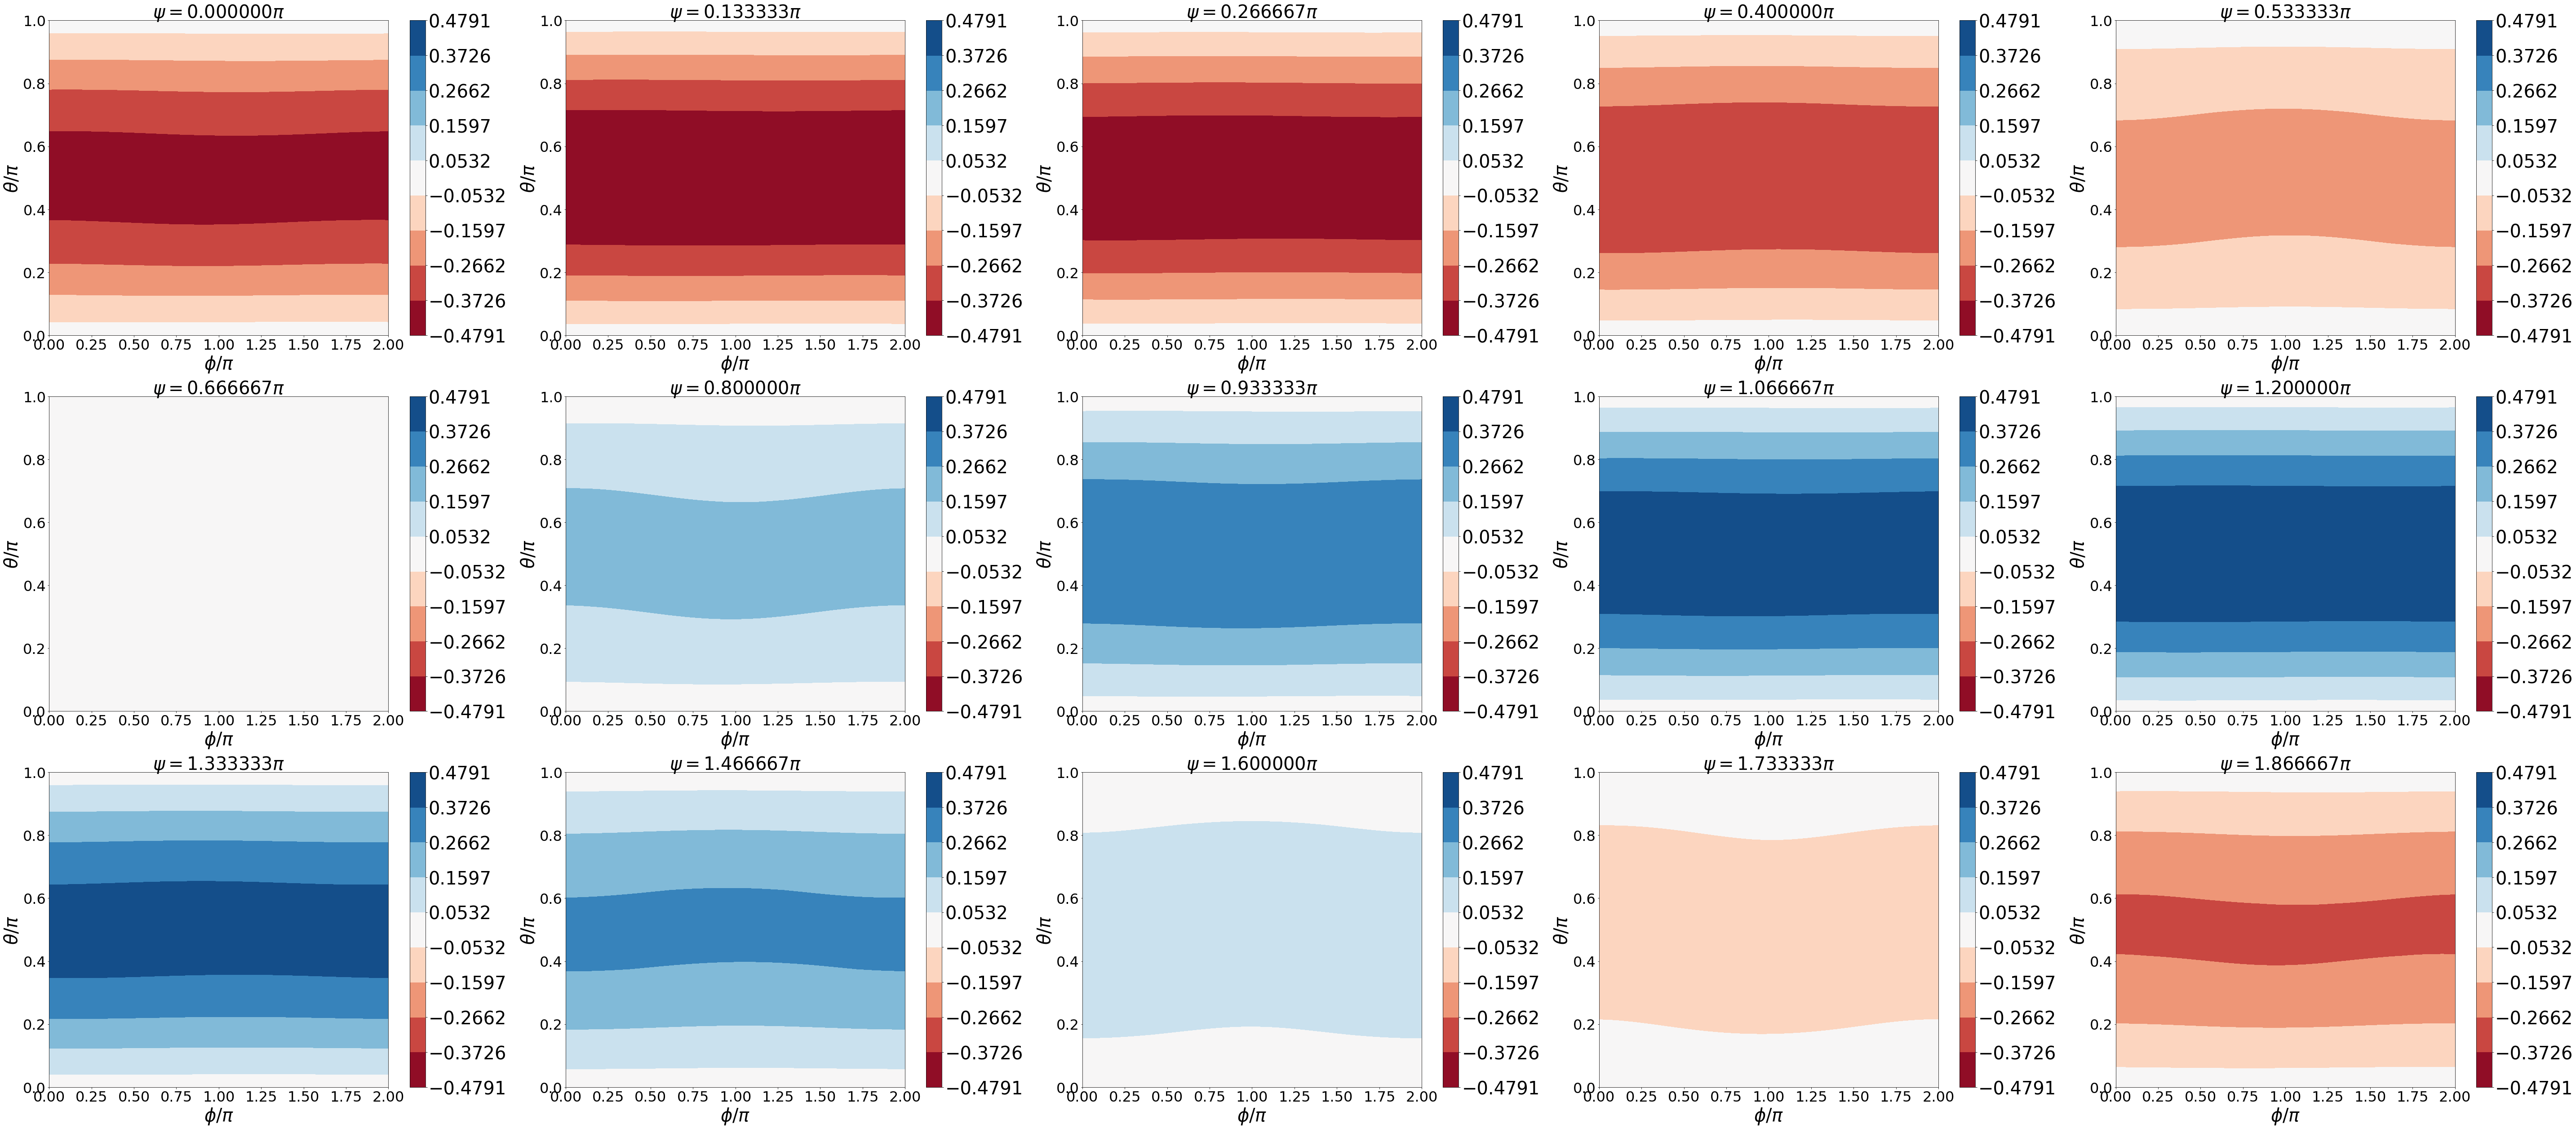

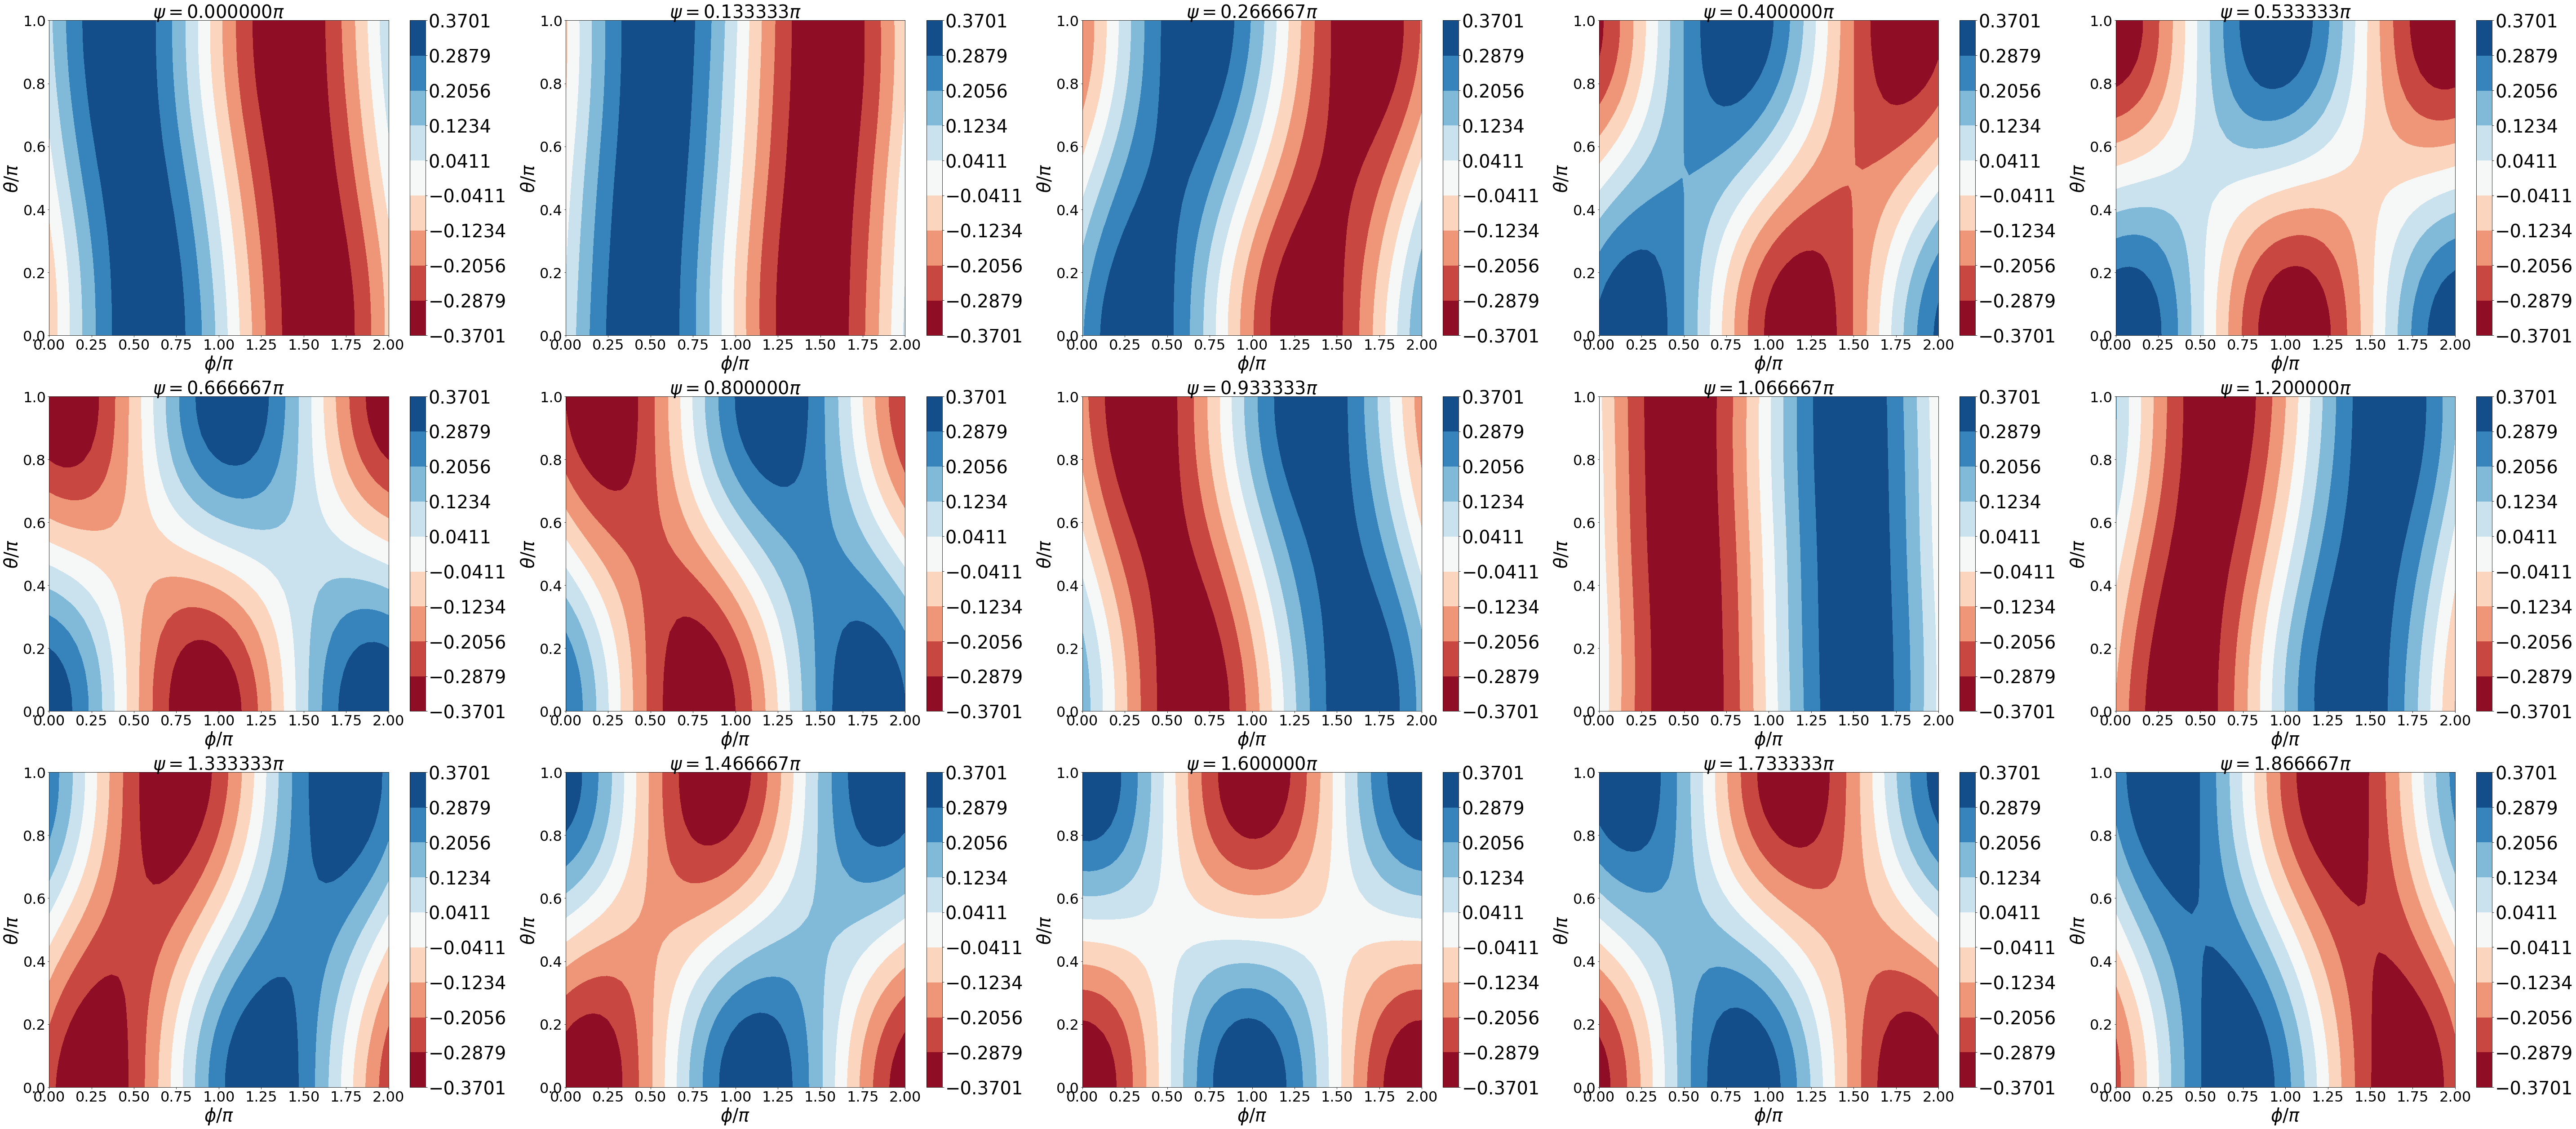

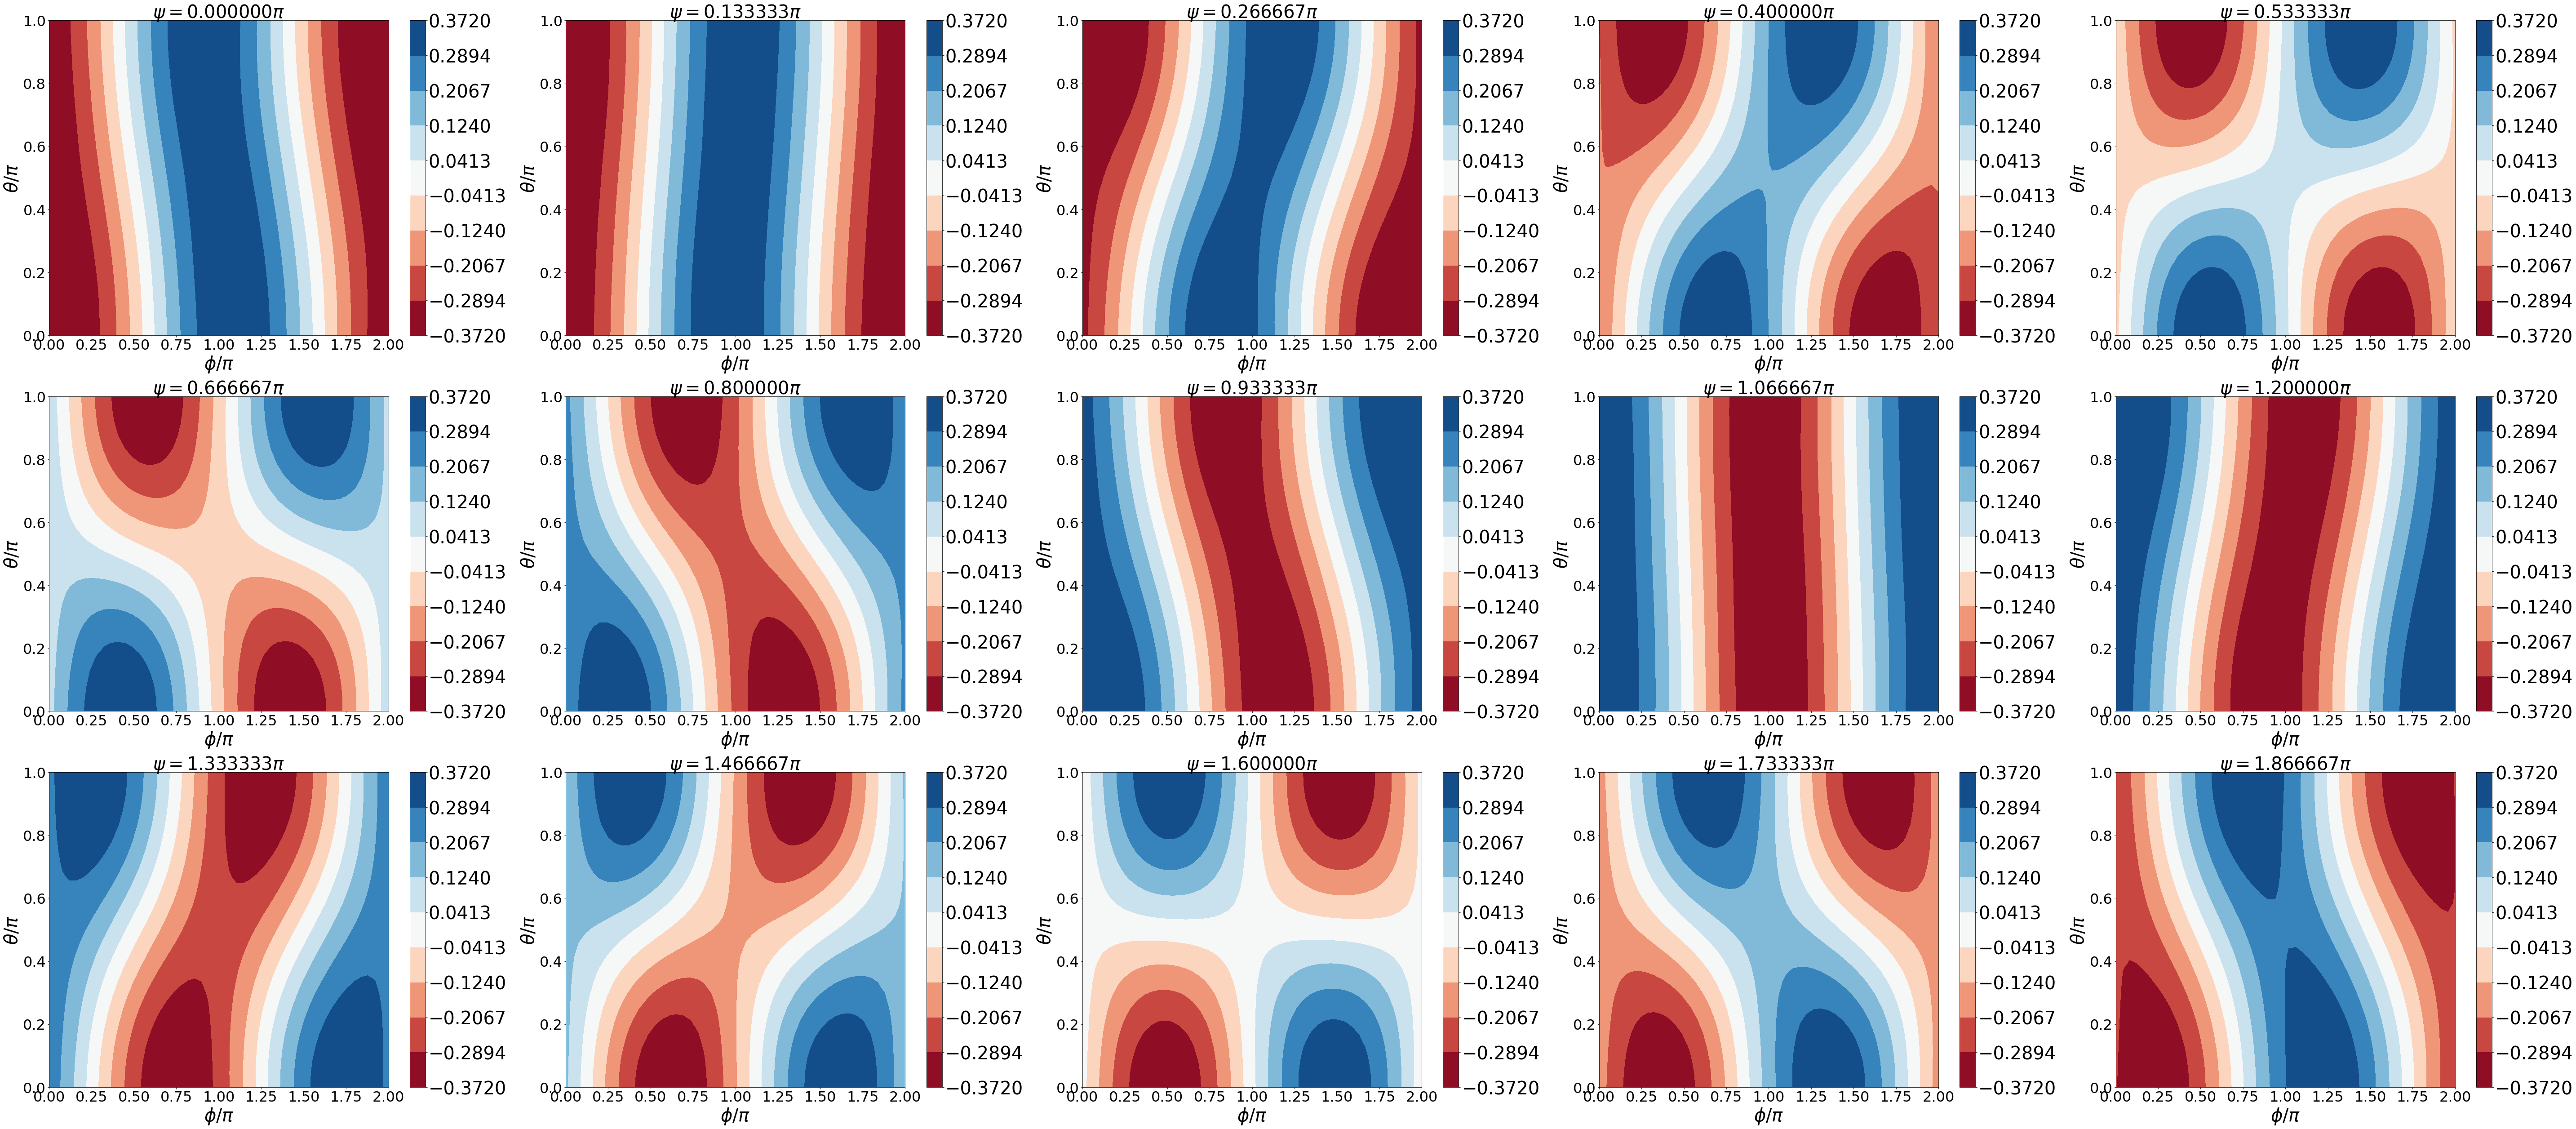

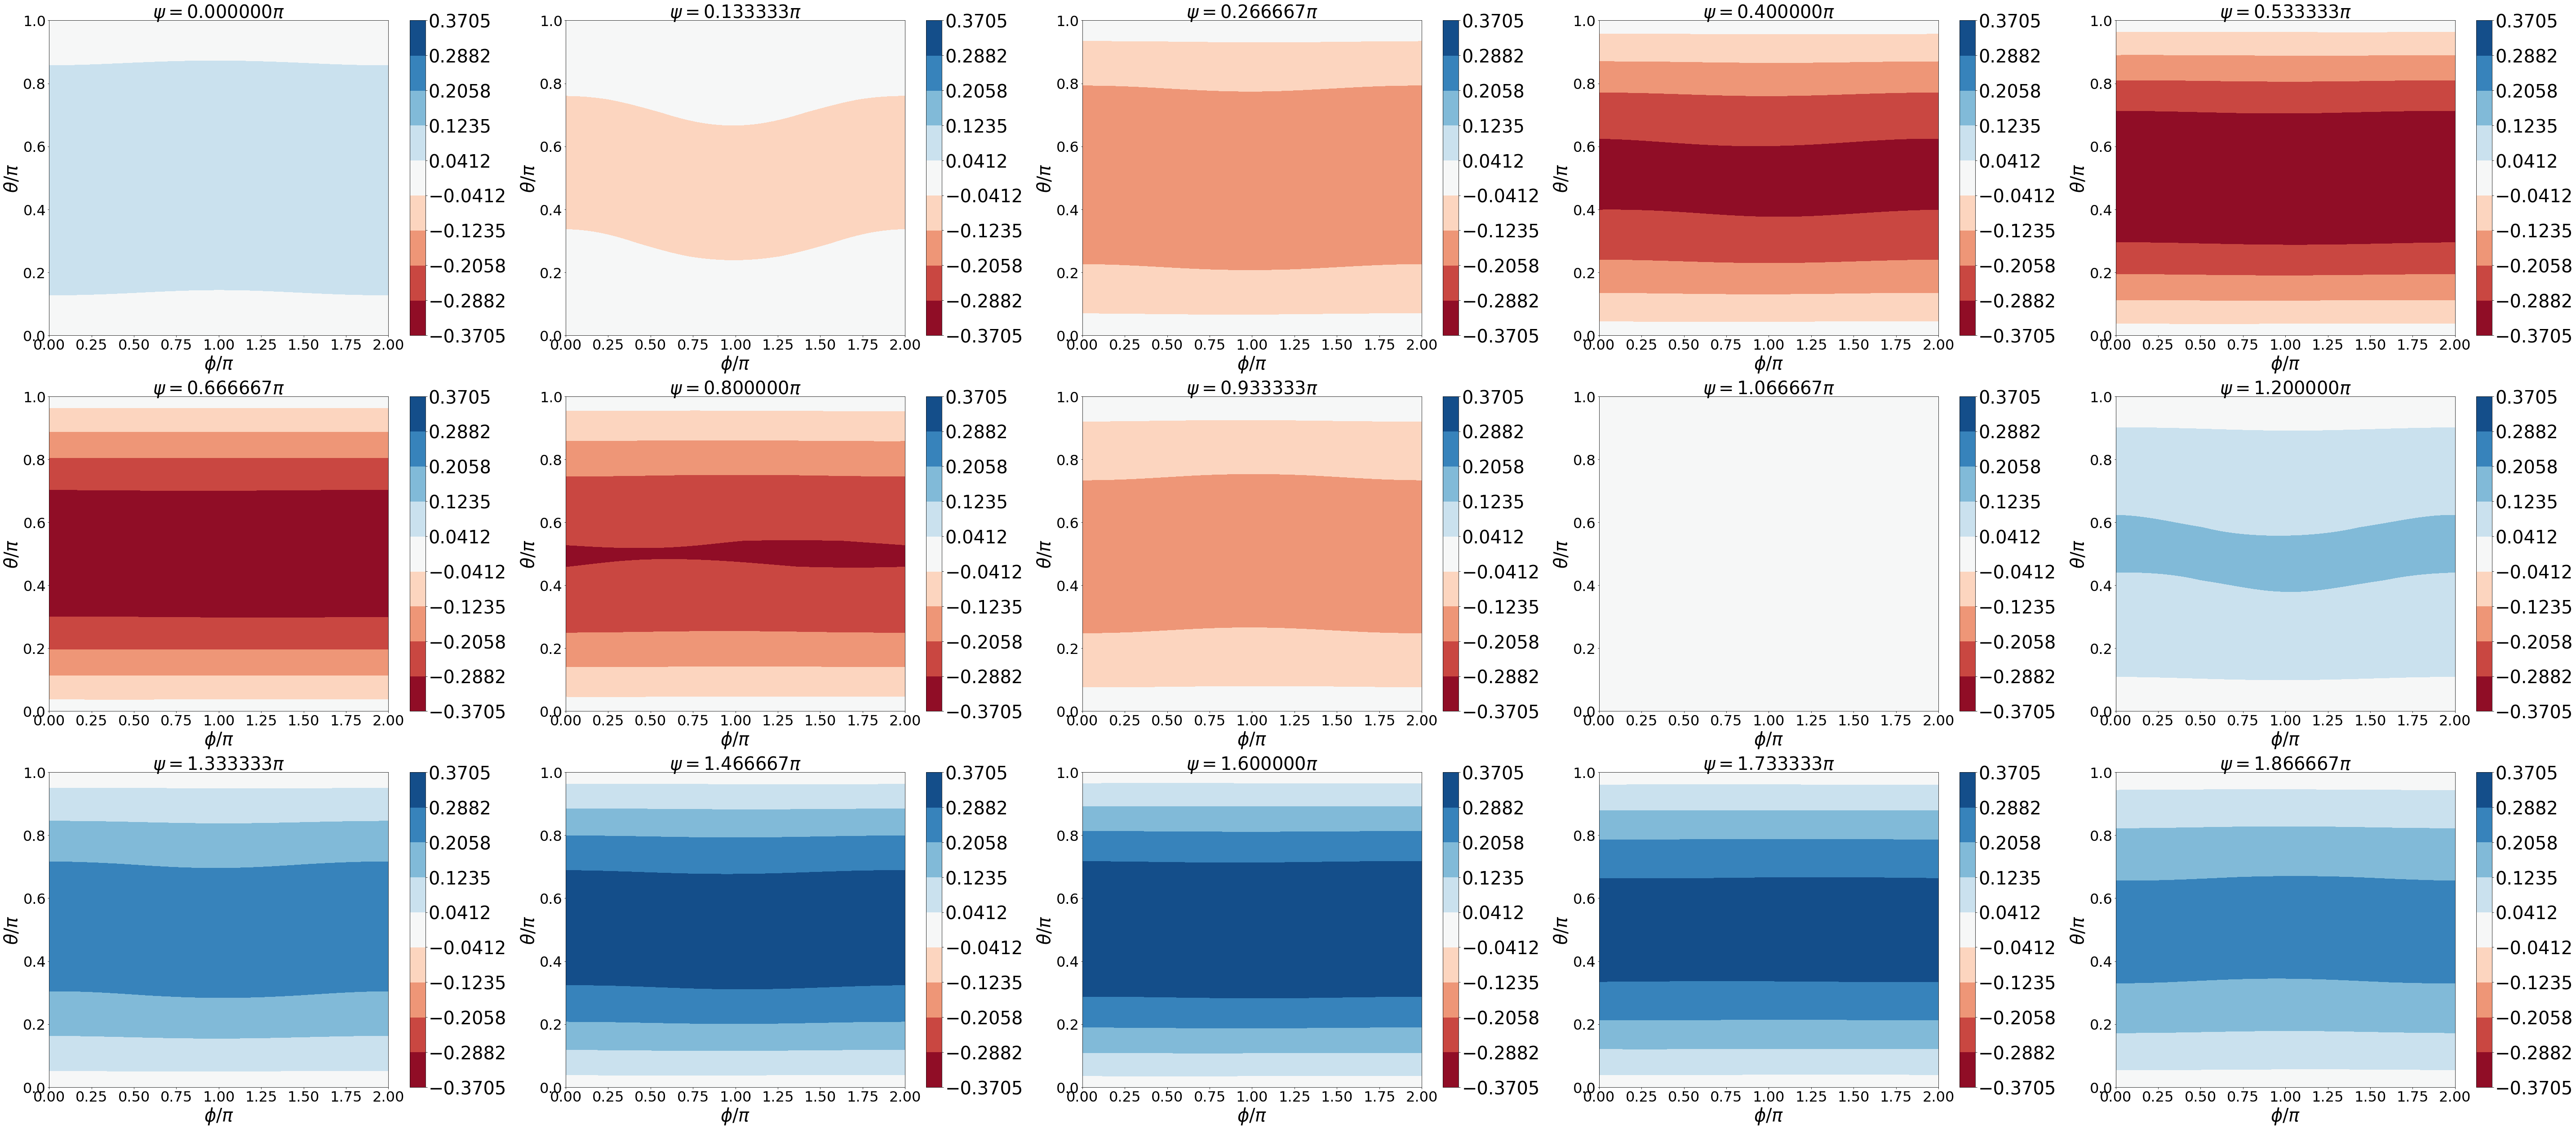

In [64]:
# show average and the difference phase maps of (ui, wi) as function of (theta, phi)
job_dir = 'planeShearRatex_1c'

with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)
n_case = len(table_data)
    
U_avr = [table_data[0][1][0][2] * 0 for i0 in range(6)]
t_lmt = np.zeros(6)
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), i0 in zip(table_psi_data, range(len(U_avr))):
        U_avr[i0] = U_avr[i0] + tU / n_case
        t1 = np.nanmax(np.abs(tU.values))
        t_lmt[i0] = np.max((t_lmt[i0], t1))

# show average
fig = plt.figure(figsize=(60, 35))
fig.patch.set_facecolor('white')
axs = fig.subplots(nrows=2, ncols=3)
for use_U, t1, ax0 in zip(U_avr, t_lmt, axs.flatten()):
    ty = use_U.index.values
    tx = use_U.columns.values
    levels = np.linspace(-t1, t1, 10)
    im = ax0.contourf(tx / np.pi, ty / np.pi, use_U.values, 
                      levels, cmap=plt.get_cmap('RdBu'))
    ax0.set_title('average over psi' % (tpsi / np.pi), fontsize=fontsize)
    ax0.set_xlabel('$\\phi / \pi$', fontsize=fontsize)
    ax0.set_ylabel('$\\theta / \pi$', fontsize=fontsize)
    fig.colorbar(im, ax=ax0, orientation='vertical').ax.tick_params(labelsize=fontsize)
    plt.sca(ax0)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

U_all = [[] for i in range(6)]
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))

# show difference
for Ui, u_avr_i in zip(U_all, U_avr):
    t1 = []
    for _, _, _, tU in Ui:
        t1.append(np.nanmax(np.abs((tU-u_avr_i).values)))
    t1 = np.nanmax(t1) 
    fig = plt.figure(figsize=(80, 35))
    fig.patch.set_facecolor('white')
    axs = fig.subplots(nrows=3, ncols=5)
    for (tpsi, ty, tx, use_U), ax0 in zip(Ui, axs.flatten()):
        levels = np.linspace(-t1, t1, 10)
        im = ax0.contourf(tx / np.pi, ty / np.pi, use_U.values - u_avr_i.values, 
                          levels, cmap=plt.get_cmap('RdBu'))
        ax0.set_title('$\\psi=%f \pi$' % (tpsi / np.pi), fontsize=fontsize)
        ax0.set_xlabel('$\\phi / \pi$', fontsize=fontsize)
        ax0.set_ylabel('$\\theta / \pi$', fontsize=fontsize)
        fig.colorbar(im, ax=ax0, orientation='vertical').ax.tick_params(labelsize=fontsize)
        plt.sca(ax0)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()

In [67]:
# make average lookup table form existing date
job_dir = 'planeShearRatex_1d'

with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)
n_case = len(table_data)
    
U_avr = [table_data[0][1][0][2] * 0 for i0 in range(6)]
t_lmt = np.zeros(6)
for tpsi, table_psi_data in table_data:
    for (ty, tx, tU), i0 in zip(table_psi_data, range(len(U_avr))):
        U_avr[i0] = U_avr[i0] + tU / n_case
        t1 = np.nanmax(np.abs(tU.values))
        t_lmt[i0] = np.max((t_lmt[i0], t1))
        
# interpolate over 1d, psi, for ellipse case psi is fake, and it just copy the data. 
table_data = []
for tpsi in np.linspace(0, 2*np.pi, 5, endpoint=False): 
    table_psi_data = []
    for tU in U_avr:
        tx = tU.columns.values # norm_phi
        ty = tU.index.values # norm_theta
        table_psi_data.append((ty, tx, tU))
    table_data.append((tpsi, table_psi_data))
t_name = job_dir + '_avr'
with open('%s.pickle' % t_name, 'wb') as handle:
    pickle.dump(table_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save table_data to %s.pickle' % t_name)

save table_data to planeShearRatex_1d_avr.pickle


In [11]:
with open('%s.pickle' % job_dir, 'rb') as handle:
    table_data = pickle.load(handle)

intp_fun_list = []
for tpsi, table_psi_data in table_data:
    tintp_fun_list = []
    for ty, tx, tU in table_psi_data:
        tfun = interpolate.RectBivariateSpline(ty, tx, tU)
        tintp_fun_list.append(tfun)
    intp_fun_list.append(tintp_fun_list)


In [8]:
def intp_U_fun(t_theta, t_phi, t_psi):
    if 0 <= t_theta <= np.pi and 0 <= t_phi < np.pi:  # letf down
        sign_list = [1, 1, 1, 1, 1, 1]
    elif 0 <= t_theta <= np.pi and np.pi <= t_phi <= 2 * np.pi:  # right down
        t_theta = t_theta
        t_phi = 2 * np.pi - t_phi
        sign_list = [1, 1, 1, 1, 1, 1]
    else:
        raise Exception('norm_theta %f and (or) norm_phi %f out of range (0, pi) * (0, 2pi)' % (t_theta, t_phi))

    intp_U = []
    for tfun in intp_fun_list:
        t_U = []
        for intp_fun, sign in zip(tfun, sign_list):
            t_U.append(intp_fun(t_theta, t_phi) * sign)
        intp_U.append(np.hstack(t_U).flatten())
    intp_U.append(intp_U[0].copy())
    intp_U = np.vstack(intp_U)
    intp_psi = np.hstack([use_psi_list, np.pi * 2])
    intp_fun1d = interpolate.interp1d(intp_psi, intp_U, kind='quadratic', axis=0, fill_value='extrapolate')
    return intp_fun1d(t_psi)


for t_use_U, t_use_Uidx in zip((ecoli_U0, ecoli_U1, ecoli_U2, ecoli_U3, ecoli_U4, ecoli_U5), 
                               (0, 1, 2, 3, 4, 5, )):
# for t_use_U, t_use_Uidx in zip((ecoli_U0, ecoli_U1, ecoli_U2, ecoli_U3, ecoli_U4, ecoli_U5), 
#                                (0, )):
    t1 = np.nanmax(np.abs(t_use_U.values))
    fig = plt.figure(figsize=(80, 35))
    fig.patch.set_facecolor('white')
    axs = fig.subplots(nrows=3, ncols=5)
    for tpsi, ax0 in zip(use_psi_list, axs.flatten()):
        use_U = t_use_U[tpsi].unstack()
        levels = np.linspace(-t1, t1, 10)
        im = ax0.contourf(use_phi_list / np.pi, use_theta_list / np.pi, use_U.values, 
                          levels, cmap=plt.get_cmap('RdBu'))
        ax0.set_title('$\\psi=%f \pi$' % (tpsi / np.pi), fontsize=fontsize)
        ax0.set_xlabel('$\\phi / \pi$', fontsize=fontsize)
        ax0.set_ylabel('$\\theta / \pi$', fontsize=fontsize)
        fig.colorbar(im, ax=ax0, orientation='vertical').ax.tick_params(labelsize=fontsize)
        plt.sca(ax0)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()


NameError: name 'ecoli_U0' is not defined

In [87]:
ntpath.basename(mati)

'ecoC01B05_all_psi0.00_th0.000000_phi0.000000_psi_0.000000.mat'

In [113]:
import ntpath

mati = '/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B05_T1/ecoC01B05_all_psi0.00/ecoC01B05_all_psi0.00_th0.000000_phi0.000000_psi_0.000000.mat'
mat_contents = loadmat(mati)
norm_theta = mat_contents['norm_theta'].flatten()[0]
norm_phi = mat_contents['norm_phi'].flatten()[0]
norm_psi = mat_contents['norm_psi'].flatten()[0]
planeShearRate = mat_contents['planeShearRate']
ecoli_center = mat_contents['ecoli_center']
ecoli_nodes = mat_contents['ecoli_nodes']
ecoli_norm = mat_contents['ecoli_norm']
ecoli_U = mat_contents['ecoli_U']
tail_rel_U = mat_contents['tail_rel_U']

mat_name = mati + '.bck'
print(mat_name)
savemat(mat_name, {
    'norm_theta':     norm_theta,
    'norm_phi':       norm_phi,
    'norm_psi':       norm_psi,
    'planeShearRate': planeShearRate,
    'ecoli_center':   ecoli_center,
    'ecoli_nodes':    ecoli_nodes,
    'ecoli_norm':     ecoli_norm,
    'ecoli_U':        ecoli_U,
    'tail_rel_U':     tail_rel_U}, oned_as='column', )

/home/zhangji/stokes_flow_master/head_Force/loop_table/ecoC01B05_T1/ecoC01B05_all_psi0.00/ecoC01B05_all_psi0.00_th0.000000_phi0.000000_psi_0.000000.mat.bck


In [12]:
0.004626764756740716 * 0.75

0.003470073567555537